# <div style='padding:25px;background-color:maroon;color:white;border-radius:4px;font-size:100%;text-align: center'>Banking Data Analysis<br></div>

## <span style="color:Aqua;">Importing libraries from Python</span>

In [1]:
import pandas as pd
pd.options.display.max_columns = 50
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)


import numpy as np
import math
from scipy.stats import pearsonr,kstest, norm, skew,kurtosis, boxcox
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.color': 'black',  # Change font color
    'axes.labelcolor': 'black',  # Change axis label color
    'xtick.color': 'black',  # Change x-tick color
    'ytick.color': 'black',  # Change y-tick color
    'font.weight': 'bold',  # Change font weight
    'axes.titleweight': 'bold',  # Change title weight
    'axes.labelweight': 'bold',# Change label weight
})


color_good = '\033[32m'   # Dark Green for near-zero skew
color_okay = '\033[92m'   # Light Green for slightly positive or slightly negative skew
color_bad = '\033[91m'    # Maroon for significant skew
color_neutral = '\033[0m' # Reset color

### <span style="color:Khaki;">Reading cleaned Dataset:

In [2]:
df=pd.read_feather('Cleaned_data.feather')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           1000 non-null   int16         
 1   age                          1000 non-null   int8          
 2   policy_bind_date             1000 non-null   datetime64[ns]
 3   policy_state                 1000 non-null   category      
 4   policy_deductable            1000 non-null   int16         
 5   policy_annual_premium        1000 non-null   float64       
 6   insured_sex                  1000 non-null   category      
 7   insured_education_level      1000 non-null   category      
 8   insured_occupation           1000 non-null   category      
 9   insured_hobbies              1000 non-null   category      
 10  insured_relationship         1000 non-null   category      
 11  incident_date                1000 non-null  

In [4]:
df.sample(3)

months_as_customer  age policy_bind_date policy_state  policy_deductable  \
172                  73   29       1993-01-29           IL               1000   
121                 206   36       2009-07-23           IL                500   
249                  94   30       2002-03-01           IN               2000   

     policy_annual_premium insured_sex insured_education_level  \
172              1447.7800        MALE                 College   
121              1625.4500      FEMALE                      MD   
249              1025.5400      FEMALE             High School   

    insured_occupation insured_hobbies insured_relationship incident_date  \
172    protective-serv     board-games                 wife    2015-01-10   
121      other-service     video-games       other-relative    2015-01-23   
249       armed-forces       paintball       other-relative    2015-02-20   

                incident_type   collision_type incident_severity  \
172   Multi-vehicle Collision   Rear Collision        Total Loss   
121  Single Vehicle Collision  Front Collision      Major Damage   
249  Single Vehicle Collision   Rear Collision      Major Damage   

    authorities_contacted incident_state incident_city  \
172                 Other             SC     Arlington   
121             Ambulance             NY    Northbrook   
249                  Fire             NC     Arlington   

    incident_hour_of_the_day number_of_vehicles_involved property_damage  \
172                       15                           3             YES   
121                       11                           1              NO   
249                       19                           1             YES   

    bodily_injuries witnesses police_report_available  total_claim_amount  \
172               1         0                      NO               44910   
121               2         1                      NO               76560   
249               1         3                     YES               64100   

     injury_claim  property_claim  vehicle_claim  auto_make auto_year  \
172          4990            4990          34930      Dodge      2001   
121         12760           12760          51040       Ford      2008   
249          6410            6410          51280  Chevrolet      2001   

    fraud_reported  
172              N  
121              Y  
249              N

## <span style="color:Aqua;">Defining variable type:

<span style="color: Chartreuse;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &#9784; </span> On a high level we can categorize data into two types <span style="color: Chartreuse;"> Continuous and Categorial </span> In this section we are gonna split features based on the nature of it's type.<br>



   <span style="color: Chartreuse;font-size:130%;"> &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&#9830; </span> Continuous variables can take any value within a range and can habe infinite possible values. 
      <p> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;Example - `annual_income`, `age`, `Num of bank accounts`, etc. </p>

   <span style="color: Chartreuse;font-size:130%;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9830; </span> Continuous Categorial variables have categories with specific order or ranking or represent categories without any inherent or order or ranking. 
      <p> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;- Example - `credit_mix`,`name`, etc.</p>

In [5]:
continuous = ['age', 'policy_deductable',
       'policy_annual_premium', 'total_claim_amount', 'injury_claim',
       'property_claim', 'vehicle_claim']

categorical = ['policy_state', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'property_damage', 'bodily_injuries', 'witnesses',
       'police_report_available', 'auto_make', 'auto_year', 'fraud_reported']

In [6]:
print(len(continuous) ,'+',  len(categorical),len(continuous) + len(categorical))
print(df.shape[1] - 3) # removing 3 time columns

7 + 21 28
28


## <p style="color:Aqua;"> Exploratory Data Analysis. Before Handling Skewness, Kurtosis and Outliers</p>

### <p style="color:Khaki;">Before we move further it's crucial to understand the importance of handling <span style="color: Chartreuse;"> Outliers, Normality, Skewness, and Kurtosis </span> and their impact on the ML model performance.

#### <span style="color: Tomato;font-size:130%;"><u> Outliers</u>:- </span> 
Outliers are data points that are significantly different from most other data points in a variable (column). Example, most people in a dataset have an annual income between $20,000 and $100,000, but one person has an income of $1,000,000, that person is an outlier.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> Example:- </span> Most people in a dataset have an annual income between $20,000 and $100,000, but one person has an income of $1,000,000, that person is an outlier.

<span style="color: Chartreuse;font-size:120%;"> &nbsp; &nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> Impact on Model:- </span> Outliers can skew the results of our analysis and make our model less accurate. For example, if we're predicting loan approval, an outlier income might distort the overall understanding of what typical incomes look like, leading to poor predictions.

#### <span style="color: Tomato;font-size:130%;"> <u>Normality</u>:- 
</span>Normality refers to how data is distributed. In a "normal" distribution, data is symmetrically distributed around the mean (average), forming a bell-shaped curve when we plot a line chart.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> Example:- </span> Imagine measuring the height of adults in a city. Most people would fall around the average height, with fewer people being extremely short or extremely tall, forming a bell curve.

<span style="color: Chartreuse;font-size:120%;"> &nbsp; &nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> Impact on Model:- </span> Many statistical models assume that the data follows a normal distribution. If our data is not normally distributed, the model might not perform as well, leading to inaccurate predictions.

#### <span style="color: Tomato;font-size:130%;"> <u>Skewness</u>:- 
</span>Skewness measures the asymmetry of the data distribution. If data is skewed, it means that it is not evenly distributed around the mean.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> <u>Types of Skewness</u>:- </span><br>

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9824; </span><span style="color: Tomato;font-size:100%;"> Positive Skew (Right Skew):- </span> Most data points are clustered on the left with a few high values stretching out to the right.<br>

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9824; </span><span style="color: Tomato;font-size:100%;"> Negative Skew (Left Skew):- </span> Most data points are clustered on the right with a few low values stretching out to the left.

<span style="color: Chartreuse;font-size:120%;"> &nbsp; &nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> Impact on Model:- </span> Skewed data can affect the performance of our model by giving more weight to the tail-end values, which might not be representative of the majority of our data.

#### <span style="color: Tomato;font-size:130%;"> <u>Kurtosis</u>:- 
</span>Kurtosis measures the "tailedness" of the data distribution. It tells us how much data is in the tails and the peak compared to a normal distribution.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> <u>Types of Kurtosis</u>:- </span><br>

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9824; </span><span style="color: Tomato;font-size:100%;"> High Kurtosis:- </span> Data has heavy tails and a sharp peak, indicating more extreme values.<br>

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9824; </span><span style="color: Tomato;font-size:100%;"> Low Kurtosis:- </span> Data has light tails and a flatter peak, indicating fewer extreme values.

<span style="color: Chartreuse;font-size:120%;"> &nbsp; &nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> Impact on Model:- </span> High kurtosis can indicate the presence of outliers, which can affect the accuracy of our model. If the data has more extreme values than expected, our model might overestimate the variability and lead to poor predictions.

<span style="color: Chartreuse;">   &#9784; &nbsp; <span style="color: white;font-size: 120%"> Defining a function to create plots.</span></span><br>

In [7]:
def univar_num(df, col):
    plt.figure(figsize=(16, 8))
    df = df.dropna(subset=[col])


    mean=df[col].mean()
    median=df[col].median()
    mode=df[col].mode()[0]
    sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})
    plt.subplot(2, 3, 1)
    sns.histplot(data=df, x=col, kde=True, bins=50,color='maroon',fill=True)
    plt.title(f'Histogram for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean')
    plt.axvline(median, color='black', label='Median')
    plt.axvline(mode, color='darkgreen', label='Mode')
    sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)

    
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df, x=col, color='lightgrey',legend=True)
    plt.xticks(rotation=45)
    plt.title(f'Box Plot for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean')
    plt.axvline(median, color='black', label='Median')
    plt.axvline(mode, color='darkgreen', label='Mode')
    plt.legend()
    plt.tight_layout()

    
    plt.subplot(2, 3, 3)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.gca().get_lines()[1].set_color('maroon')
    plt.gca().get_lines()[0].set_color('darkgreen')
    plt.title(f'QQ Plot for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

    plt.tight_layout()
    
    plt.tight_layout()
    plt.show()

<span style="color: Chartreuse;">   &#9784; &nbsp; <span style="color: white;font-size: 120%"> Defining a function to show Kurtosis and Skewness value.</span></span><br>

In [8]:
def kurtosis_color(kurt_val):
    if -1 <= kurt_val <= 1:
        kurt_color = color_good  # Dark Green for near-zero kurtosis (good)
    elif 1 < kurt_val <= 3 or -3 <= kurt_val < -1:
        kurt_color = color_okay  # Yellow for moderate kurtosis
    else:  # kurt_val > 3 or kurt_val < -3
        kurt_color = color_bad  # Maroon for extreme kurtosis
    return kurt_color

def skewness_color(skew_val):
    if -0.5 <= skew_val <= 0.5:
        color = color_good  # Dark Green for near-zero skew
    elif 0 < skew_val <= 0.5 or -0.5 < skew_val < 0:
        color = color_okay  # Light Green for slightly positive or slightly negative skew
    else:  # skew_val > 0.5 or skew_val < -0.5
        color = color_bad  # Maroon for significant skew
    return color

<span style="color: Chartreuse;">   &#9784; &nbsp; <span style="color: white;font-size: 120%"> Defining a function to to plot</span></span><br>

In [9]:
def process_column(col):
    univar_num(df, col) 
    skew_val = df[col].skew()
    kurt = df[col].kurtosis()
    
    kurt_color = kurtosis_color(kurt)
    color = skewness_color(skew_val)
    
    skewed_col.append(col)
    
    print(f"\n\n{color}Skew for {col} is {skew_val:.4f}{color_neutral}")
    print(f"{color}Kurtosis for {col} is {kurt:.4f}{color_neutral}\n\n")


### <span style="color:Khaki;"> Descrptive Statistics:

In [10]:
df.describe().T

count                           mean  \
months_as_customer    1000.0000                       203.9540   
age                   1000.0000                        38.9480   
policy_bind_date           1000  2002-02-08 04:40:47.999999872   
policy_deductable     1000.0000                      1136.0000   
policy_annual_premium 1000.0000                      1256.4061   
incident_date              1000            2015-01-30 08:02:24   
total_claim_amount    1000.0000                     52761.9400   
injury_claim          1000.0000                      7433.4200   
property_claim        1000.0000                      7399.5700   
vehicle_claim         1000.0000                     37928.9500   

                                       min                  25%  \
months_as_customer                  0.0000             115.7500   
age                                19.0000              32.0000   
policy_bind_date       1990-01-08 00:00:00  1995-09-19 00:00:00   
policy_deductable                 500.0000             500.0000   
policy_annual_premium             433.3300            1089.6075   
incident_date          2015-01-01 00:00:00  2015-01-15 00:00:00   
total_claim_amount                100.0000           41812.5000   
injury_claim                        0.0000            4295.0000   
property_claim                      0.0000            4445.0000   
vehicle_claim                      70.0000           30292.5000   

                                       50%                  75%  \
months_as_customer                199.5000             276.2500   
age                                38.0000              44.0000   
policy_bind_date       2002-04-01 12:00:00  2008-04-21 12:00:00   
policy_deductable                1000.0000            2000.0000   
policy_annual_premium            1257.2000            1415.6950   
incident_date          2015-01-31 00:00:00  2015-02-15 00:00:00   
total_claim_amount              58055.0000           70592.5000   
injury_claim                     6775.0000           11305.0000   
property_claim                   6750.0000           10885.0000   
vehicle_claim                   42100.0000           50822.5000   

                                       max        std  
months_as_customer                479.0000   115.1132  
age                                64.0000     9.1403  
policy_bind_date       2015-02-22 00:00:00        NaN  
policy_deductable                2000.0000   611.8647  
policy_annual_premium            2047.5900   244.1674  
incident_date          2015-03-01 00:00:00        NaN  
total_claim_amount             114920.0000 26401.5332  
injury_claim                    21450.0000  4880.9519  
property_claim                  23670.0000  4824.7262  
vehicle_claim                   79560.0000 18886.2529

#### <span style="color:Khaki;"> Observations and insights from above statistical information:</span>

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Income and Debt -**</span>   There is significant income disparity, with a high standard deviation in annual income. The debt-to-income ratios and total liabilities indicate varying levels of financial burden. Monthly inhand salary follows a similar pattern.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Credit and Loans: -**</span> The number of credit cards and loans, along with credit utilization ratios, suggest diverse credit usage patterns among individuals. The max is 50%, suggesting no one in the dataset is severely overutilizing their credit. The debt-to-income ratio has a very high max value (101,912), indicating some individuals with extreme debt compared to income.
   
   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Payments -**</span> The number of delayed payments and days delayed from the due date highlight potential issues in financial management for some individuals.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Savings and Investments -**</span> The savings rate and amount invested monthly indicate varying levels of financial planning and investment behavior.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Reliability and Stability -**</span> The reliable_payment and income_stability metrics provide insights into the financial reliability and stability of individuals. The 'reliable_payment' feature has a very high max value (2500), which might be an outlier or error.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Banking and Credit Cards: -**</span> The average number of loans is 3.53, with a range from 0 to 9. The minimum value in the interest rate suggest that all of these should have atleast 1 loan or credit card but we see datapoints that do not have either loan or credit card.

### <span style="color:Khaki;">Ploting Continuous features Distribution:

<span style="color: Chartreuse;">   &#9784; &nbsp; <span style="color: white;font-size: 120%"> The below code plots Histogram, Box plot, and Q-Q plots for all Conntimuos Features:</span></span><br>

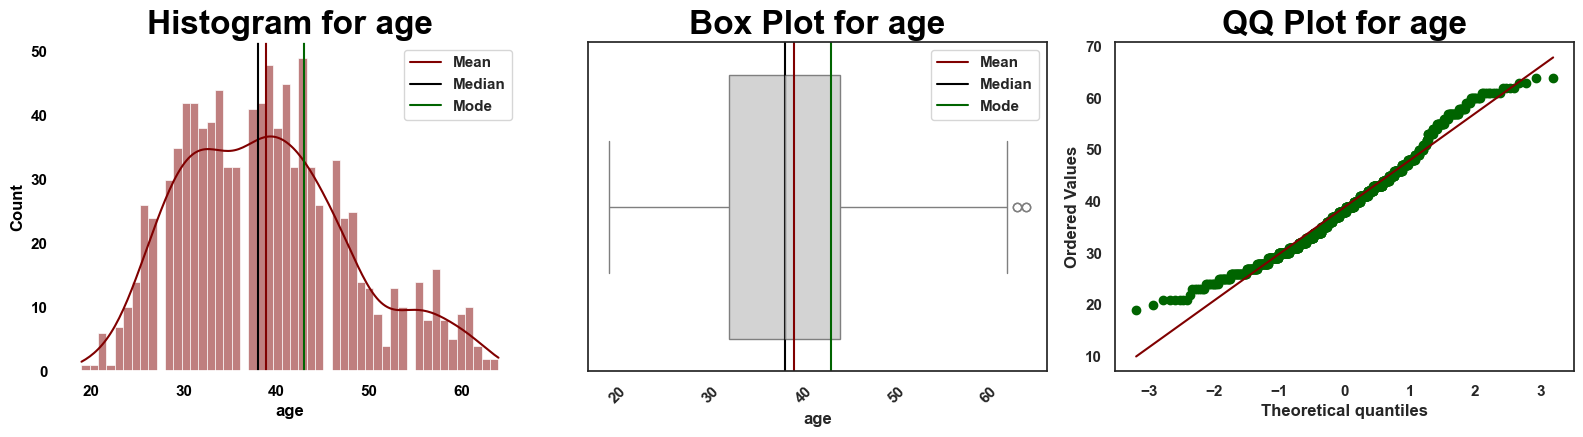



Skew for age is 0.4790
Kurtosis for age is -0.2603




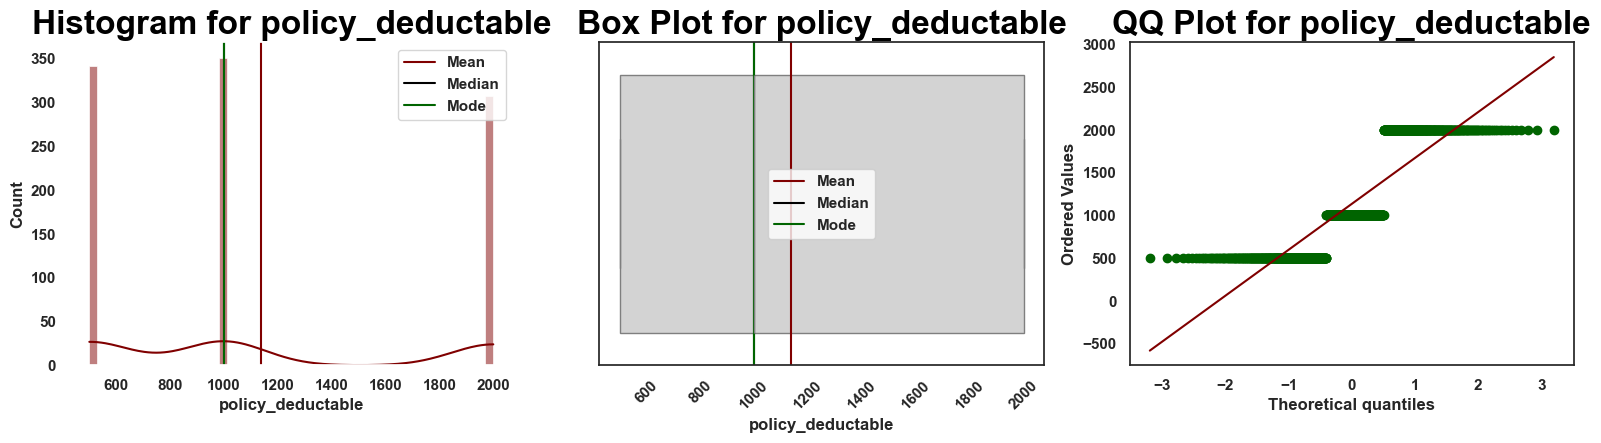



Skew for policy_deductable is 0.4779
Kurtosis for policy_deductable is -1.3769




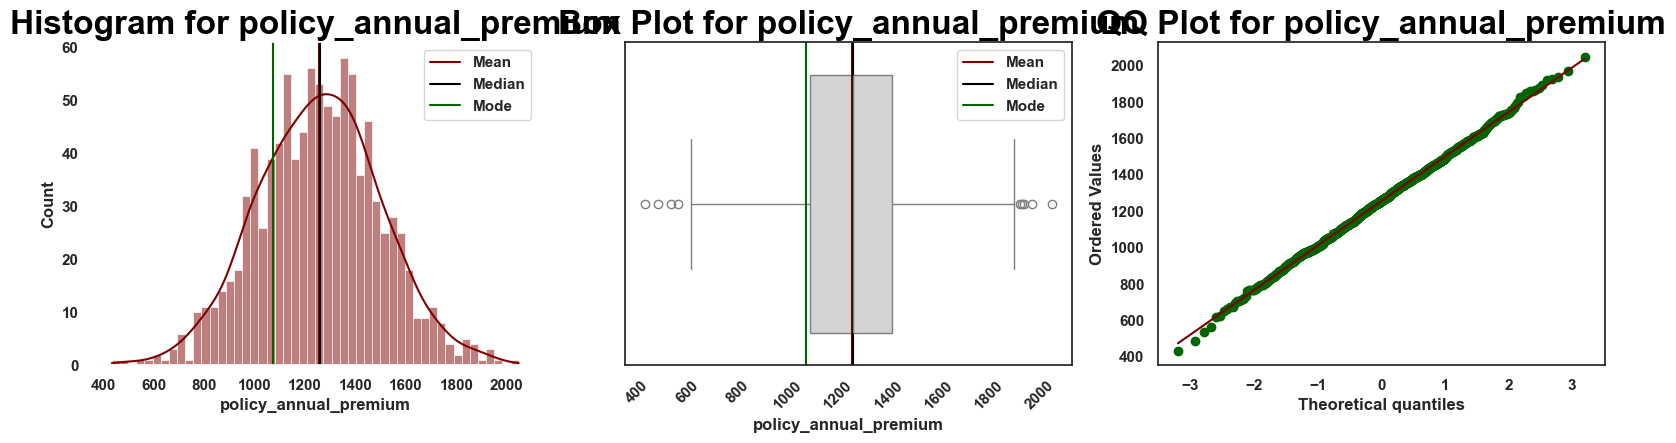



Skew for policy_annual_premium is 0.0044
Kurtosis for policy_annual_premium is 0.0739




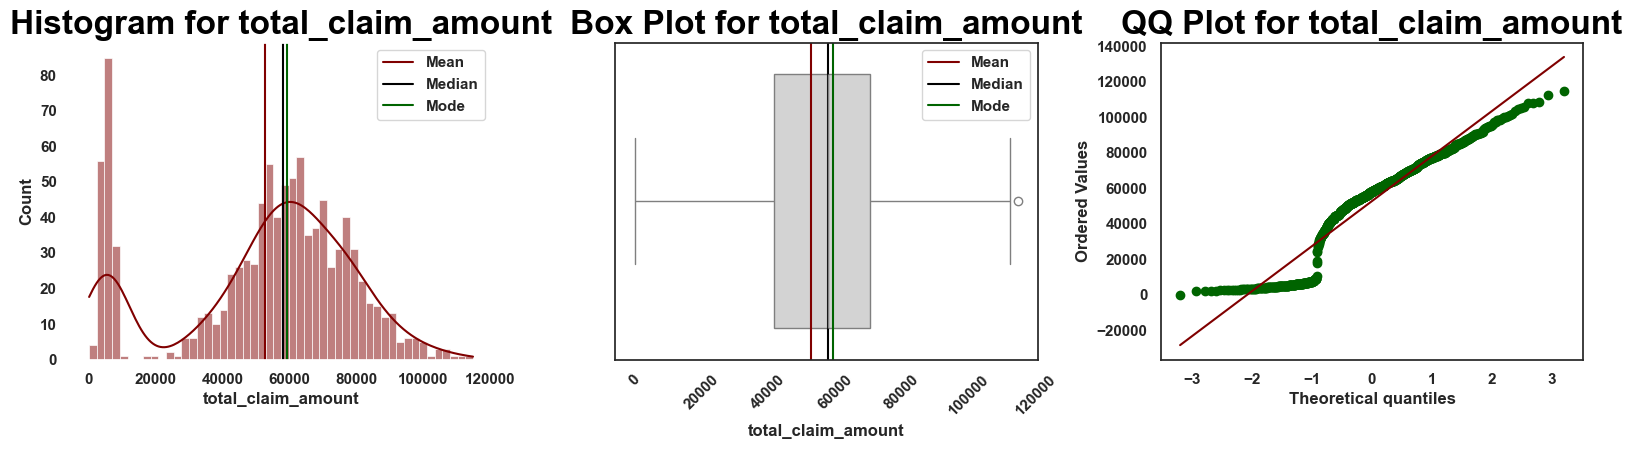



Skew for total_claim_amount is -0.5946
Kurtosis for total_claim_amount is -0.4541




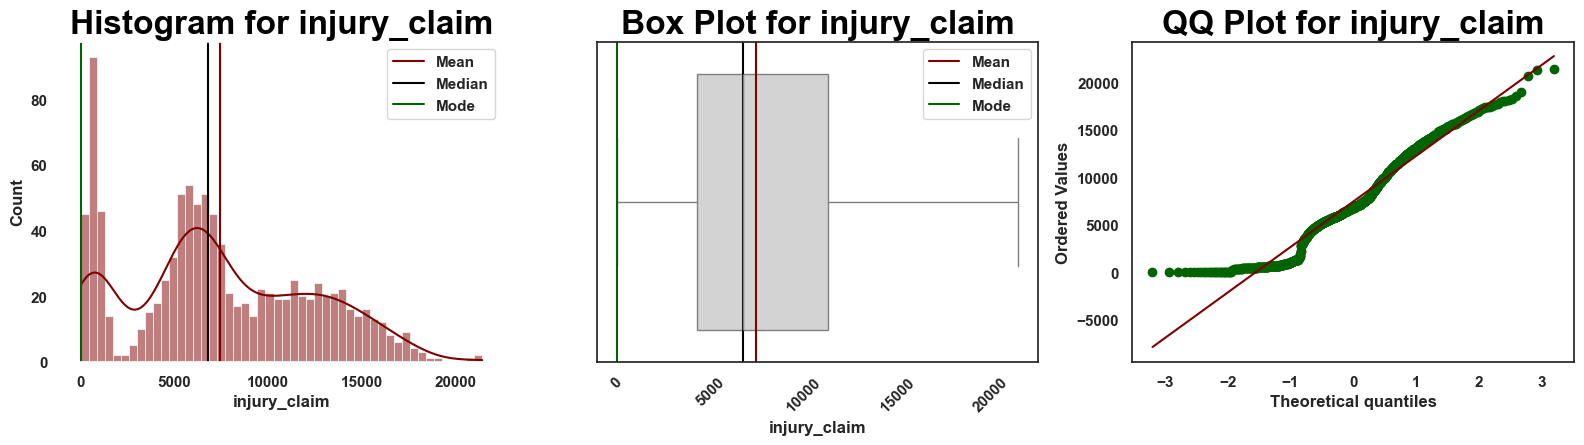



Skew for injury_claim is 0.2648
Kurtosis for injury_claim is -0.7631




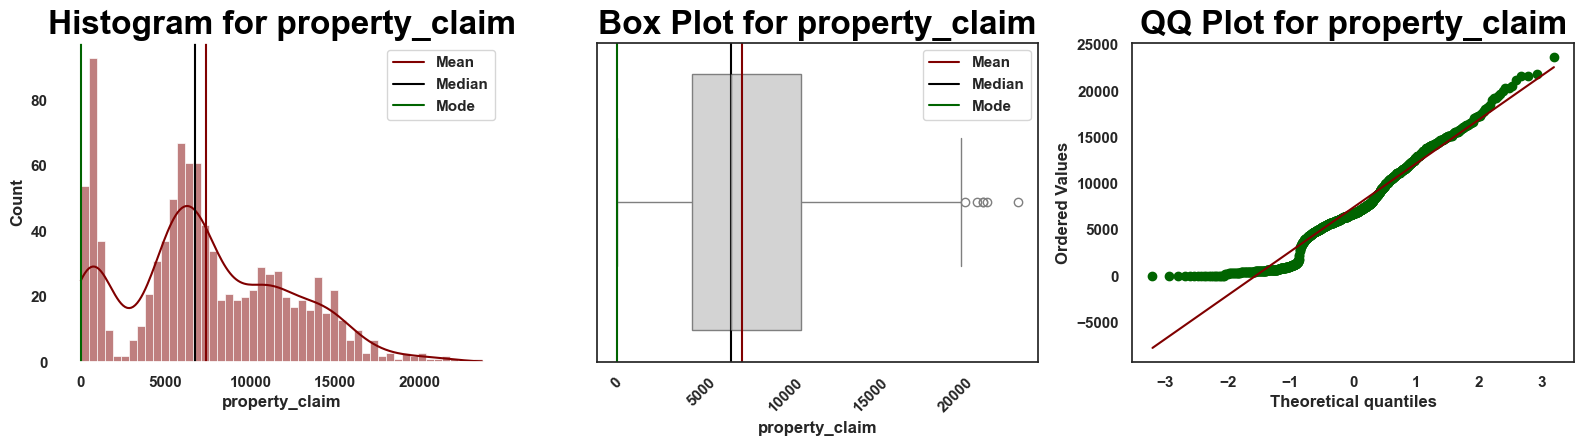



Skew for property_claim is 0.3782
Kurtosis for property_claim is -0.3764




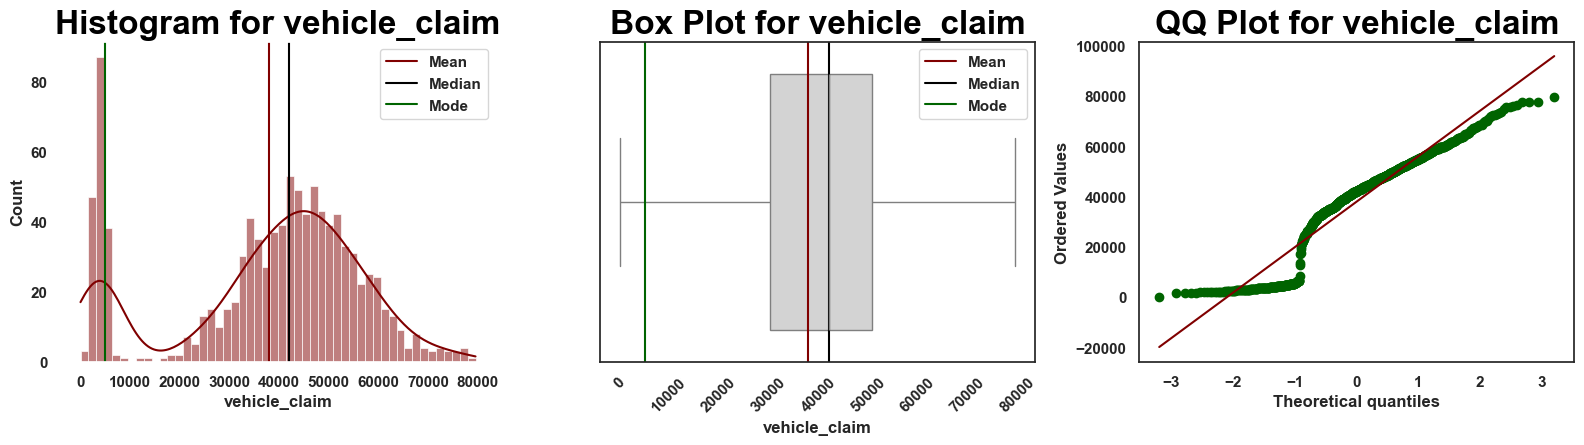



Skew for vehicle_claim is -0.6211
Kurtosis for vehicle_claim is -0.4466




In [12]:
skewed_col = []

_ = list(map(process_column, continuous)) # Apply the function to each column in the continuous list


#### <span style="color:Khaki;"> Observations and insights from plots above:</span>

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Histogram (First Plot) -**</span> A histogram is like a bar chart showing how often different values occur in your data. A smooth line (KDE) estimating the shape of data distribution.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Box-and-Whisker plot, (Second Plot) -**</span> The "box" represents the middle 50% of your data. The line in the middle of the box is the median. The "whiskers" extend to show the rest of the distribution.Points beyond the whiskers are potential outliers.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Q-Q Plot (Quantile-Quantile (Third plot)): -**</span> This plot compares your data's distribution to a theoretical normal distribution. It show how closely your data follows a normal distribution and Where and how your data deviates from normality.
   



   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Observations: -**</span> 
      - All features are right skewed (right tail) except `credit_utilization_ratio`, `credit_history_age`, `interest_rate`,`income_stability`. 
      - Effect of Skewness, we have outliers after the upper whisker (right side of the box plot).
      - Q-Q plot also confirms the same from the data deviation. The red line on the Q-Q plot is therotical line of Normal distribution and the green line is our data distrinbution.
      - All of these explains the presence of larger values but in smaller quantities.

<span style="color: Chartreuse;font-size: 130%">&#9784; &nbsp;</span> <span style="color: Tomato;font-size: 130%"> <b>We will need to use appropriate techniques like normalizing, capping outliers to certain percentile, etc, to address these issues</b></span>

### <span style="color:Khaki;">Statistival Test for Normality, Skew, Kurtosis:

Performing statustival test to confirm

In [13]:
for var in continuous:
    stat, p = kstest(df[var], 'norm', args=(df[var].mean(), df[var].std()))
    print(f'K-S Test for {var}: Statistics={stat}, p={p}')
    if p > 0.05:
        print(f'{var} looks normally distributed.\n')
    else:
        print(f'{var} does not look normally distributed.\n')


K-S Test for age: Statistics=0.06586326713162294, p=0.0003245057348046505
age does not look normally distributed.

K-S Test for policy_deductable: Statistics=0.2809486814746704, p=2.61725029571265e-70
policy_deductable does not look normally distributed.

K-S Test for policy_annual_premium: Statistics=0.011773942121742431, p=0.9988495433150195
policy_annual_premium looks normally distributed.

K-S Test for total_claim_amount: Statistics=0.12791239761192147, p=1.0078101660274144e-14
total_claim_amount does not look normally distributed.

K-S Test for injury_claim: Statistics=0.08549045300317659, p=8.30050622498833e-07
injury_claim does not look normally distributed.

K-S Test for property_claim: Statistics=0.07829325958481936, p=8.870015247047102e-06
property_claim does not look normally distributed.

K-S Test for vehicle_claim: Statistics=0.1286373422101301, p=6.925657956506968e-15
vehicle_claim does not look normally distributed.



In [14]:
for var in continuous:
    skewness = skew(df[var])
    kurt = kurtosis(df[var])
    print(f'{var} - Skewness: {skewness}, Kurtosis: {kurt}')
    if abs(skewness) < 0.5 and abs(kurt) < 3:
        print(f'{var} looks normally distributed.\n')
    else:
        print(f'{var} does not look normally distributed.\n')

age - Skewness: 0.478269265444348, Kurtosis: -0.2649495664444954
age looks normally distributed.

policy_deductable - Skewness: 0.47717008402692257, Kurtosis: -1.3760622615437708
policy_deductable looks normally distributed.

policy_annual_premium - Skewness: 0.004395388781646907, Kurtosis: 0.06752650386986625
policy_annual_premium looks normally distributed.

total_claim_amount - Skewness: -0.593689743653387, Kurtosis: -0.45780820186136495
total_claim_amount does not look normally distributed.

injury_claim - Skewness: 0.2644134965313636, Kurtosis: -0.7652709695781823
injury_claim looks normally distributed.

property_claim - Skewness: 0.37760128674511556, Kurtosis: -0.3805010189907647
property_claim looks normally distributed.

vehicle_claim - Skewness: -0.6201658958678784, Kurtosis: -0.4503371882802707
vehicle_claim does not look normally distributed.



<span style="color: Chartreuse;font-size: 130%">&#9784; &nbsp;</span> <span style="color: Tomato;font-size: 130%"> <b>Above are the another way of checking distribution and Skewness, it representing the same results as plots.</b></span>

### <span style="color:Khaki;">Categorical features Distribution

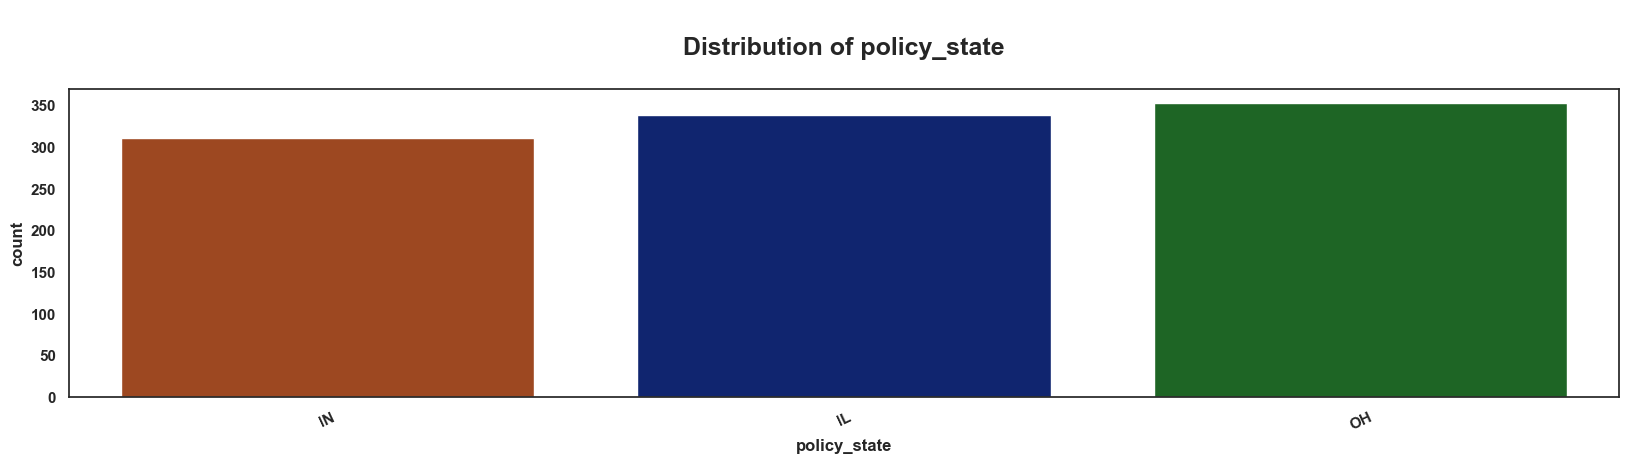

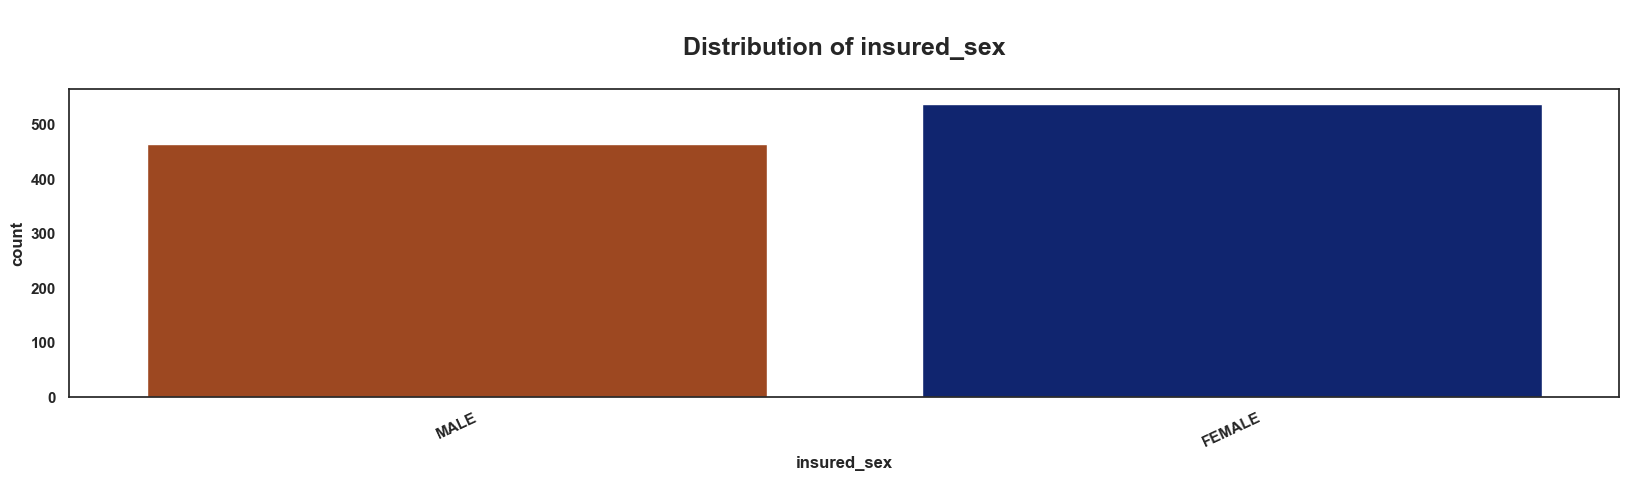

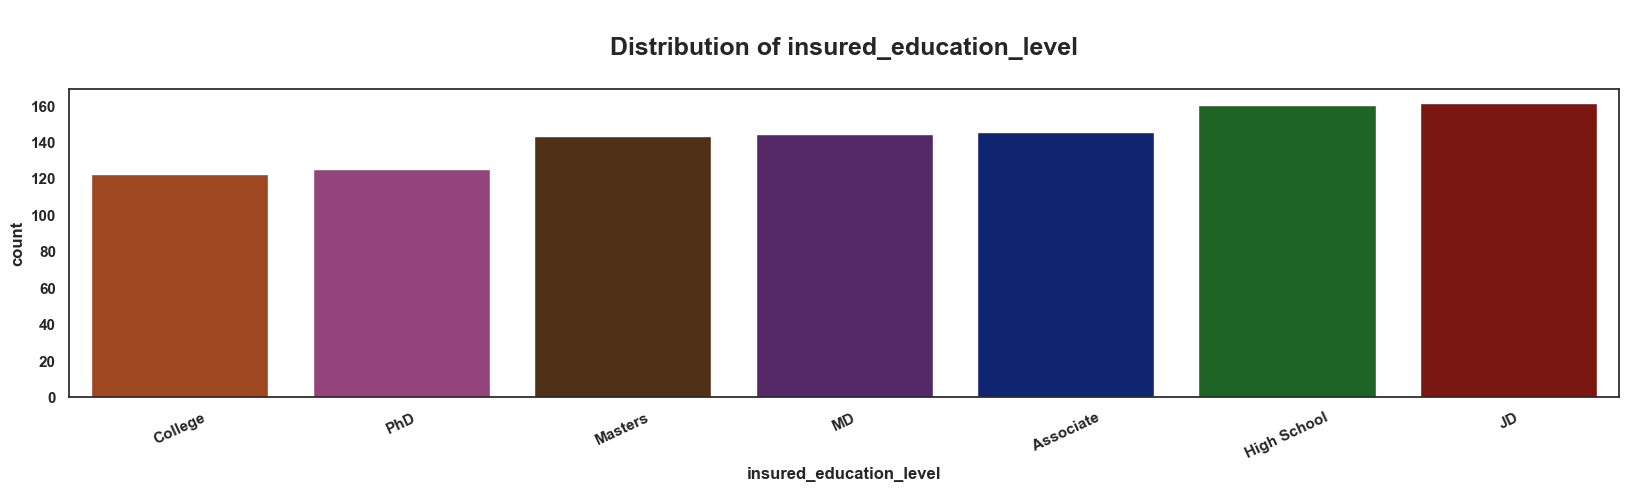

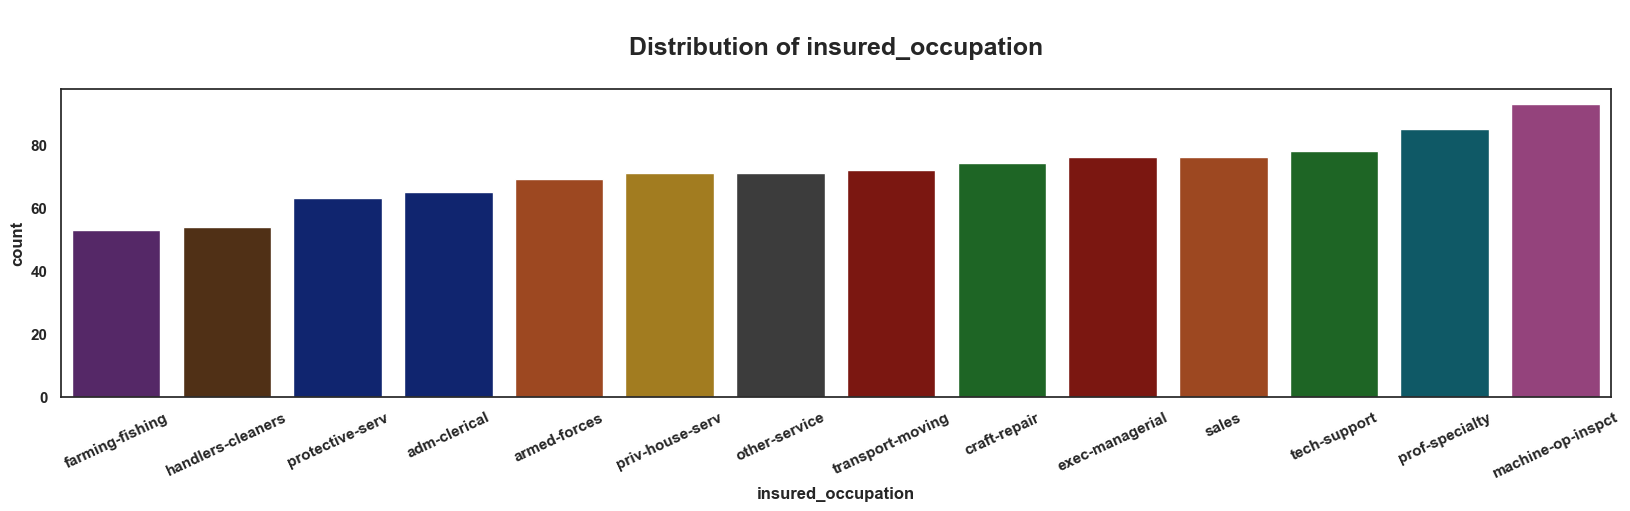

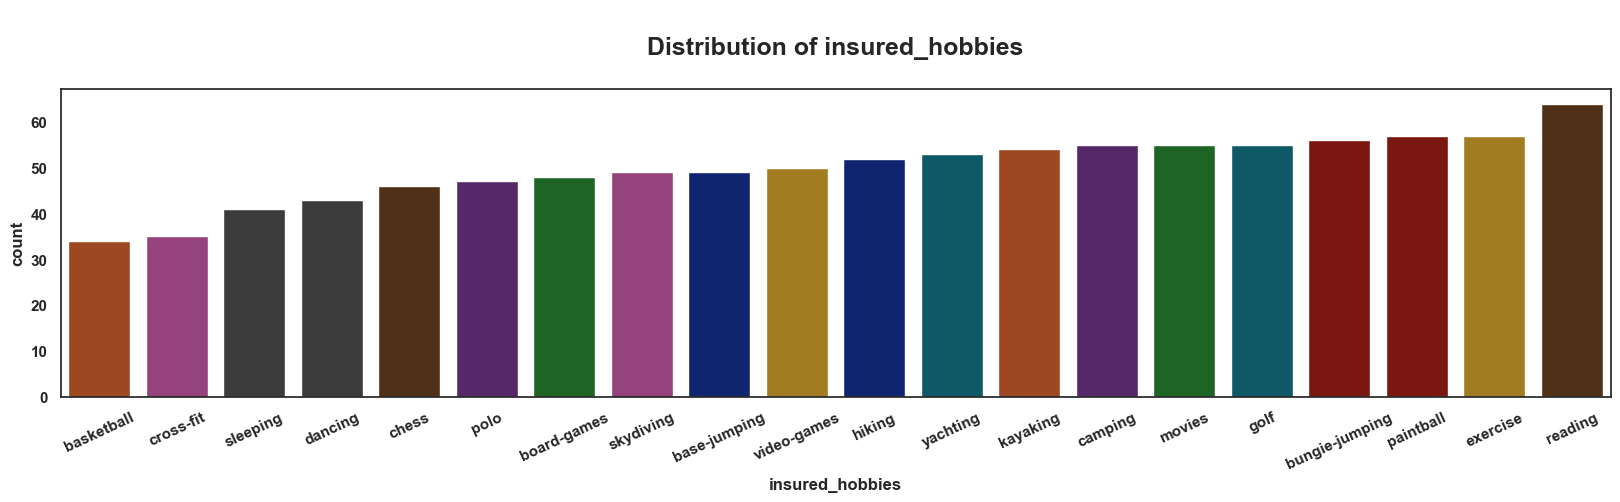

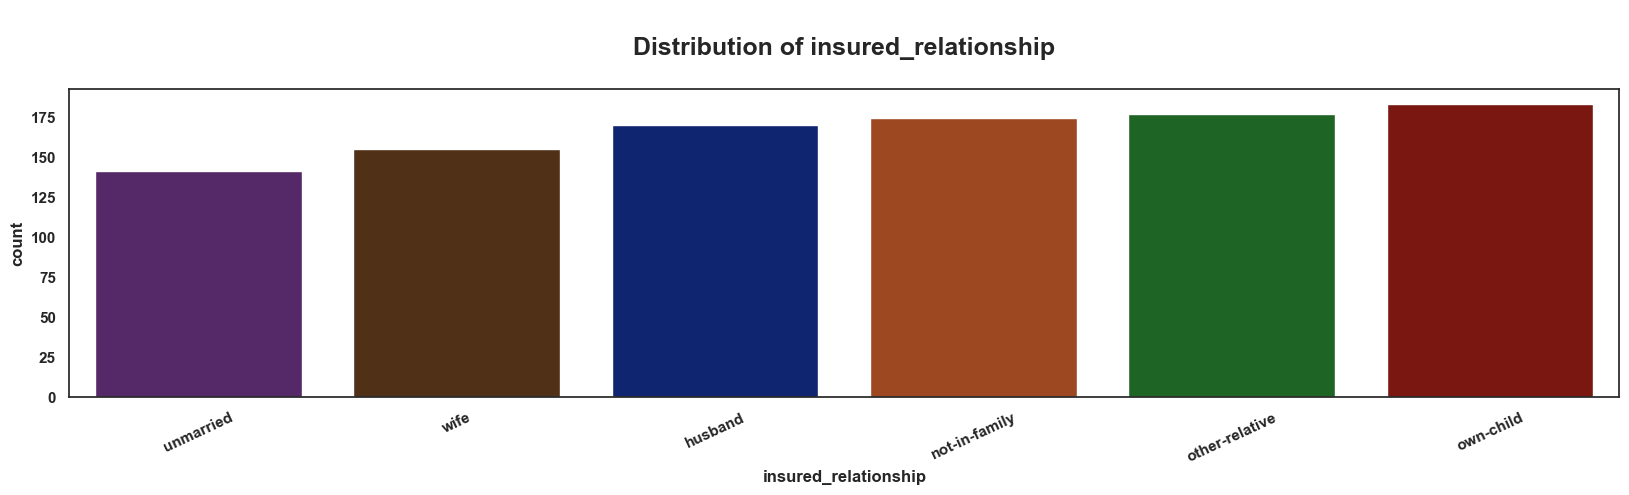

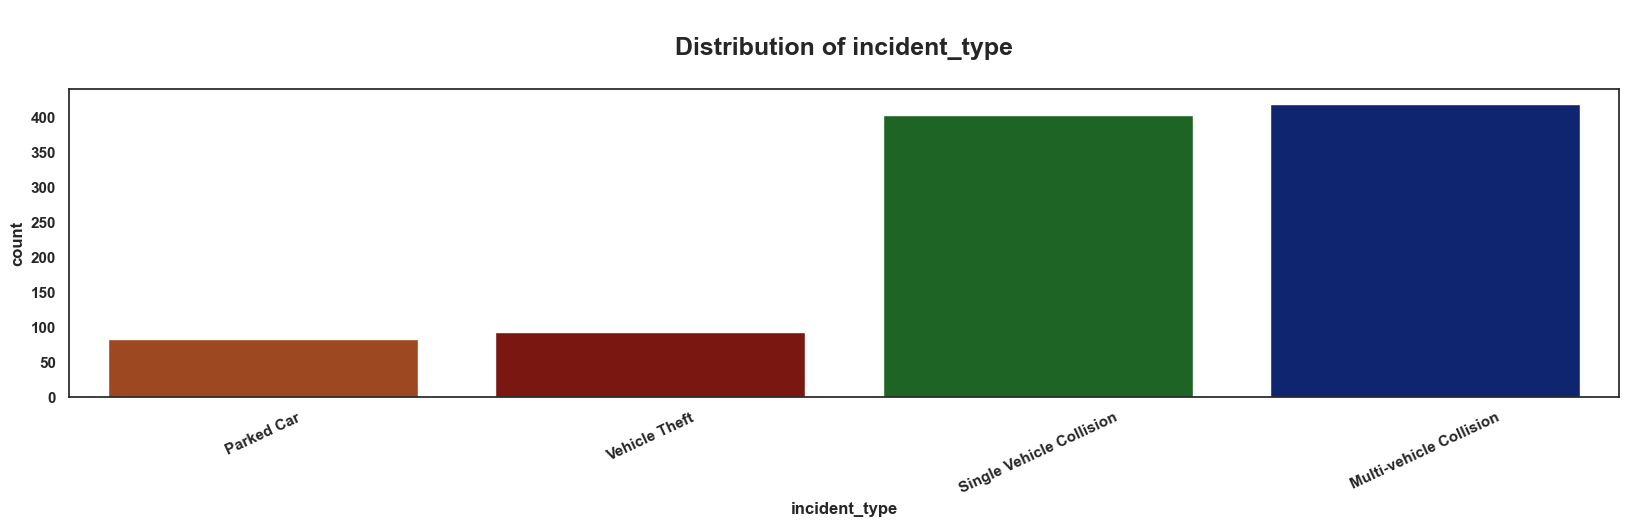

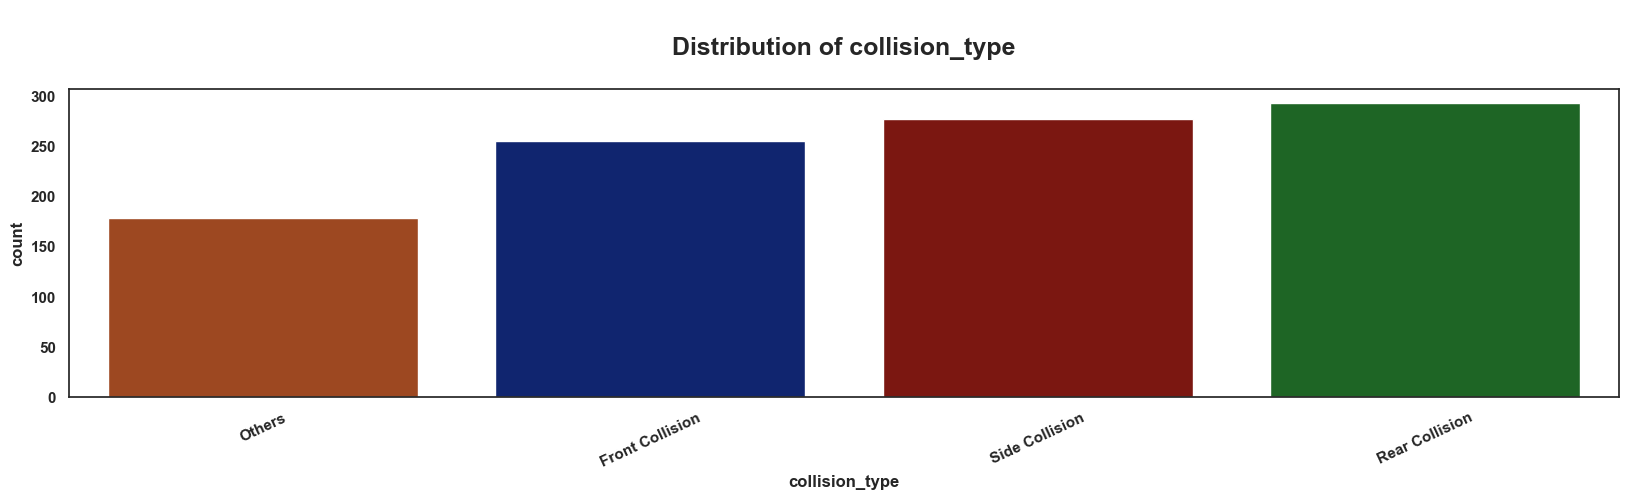

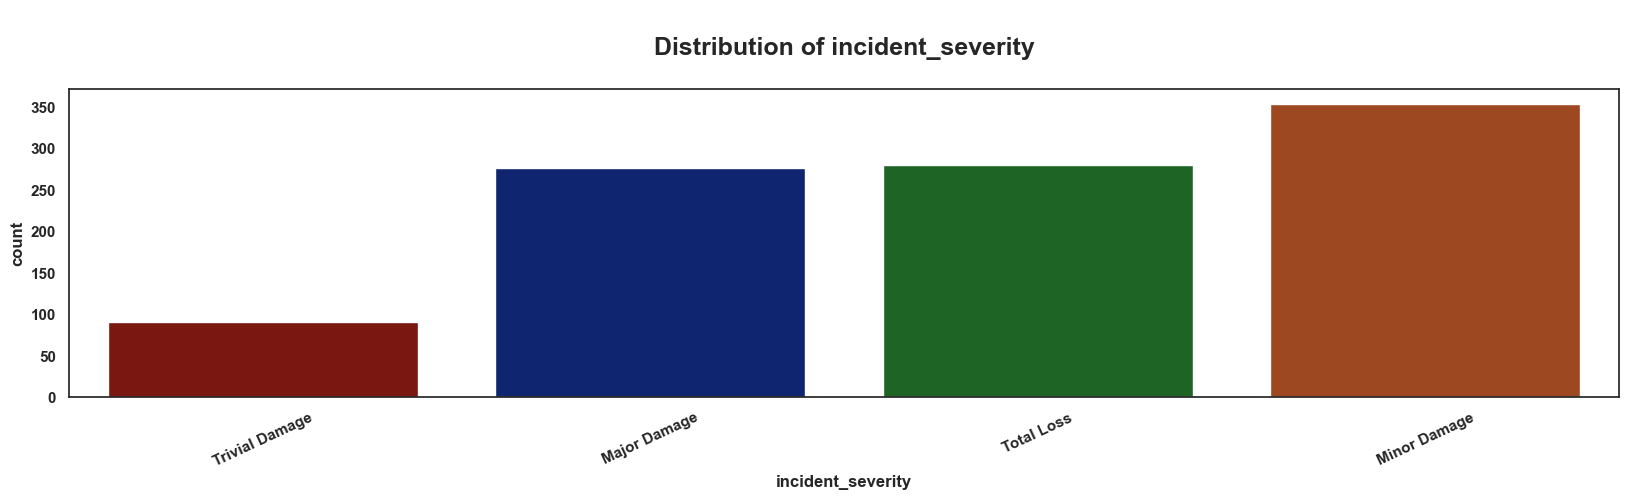

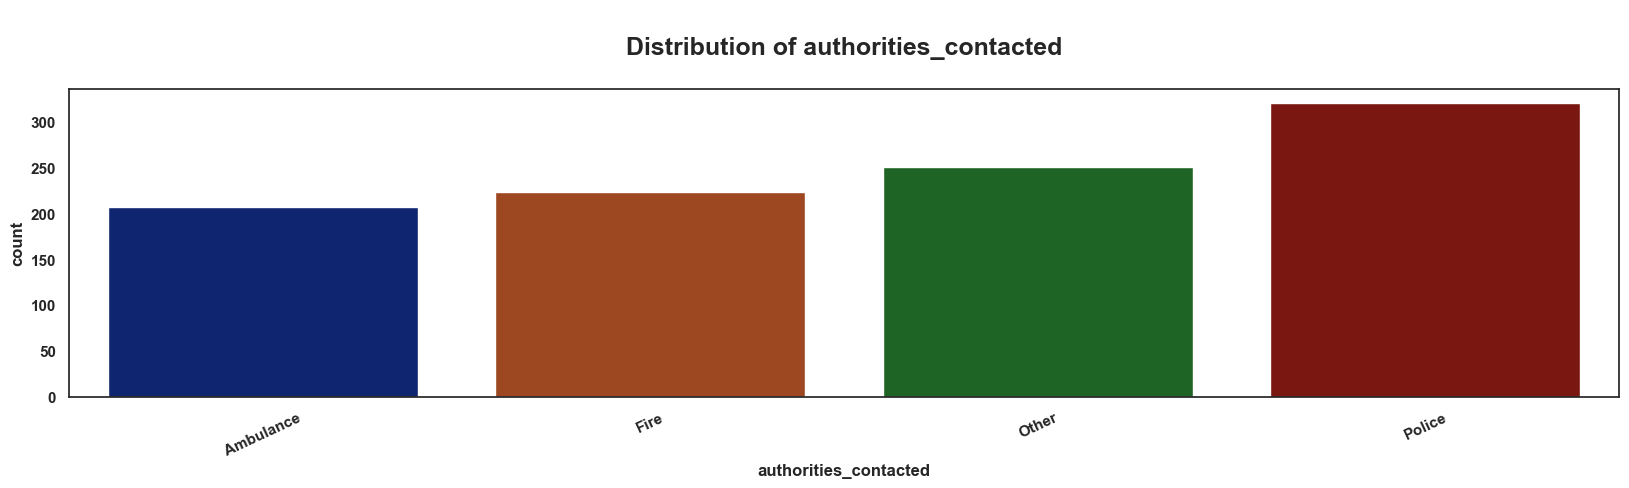

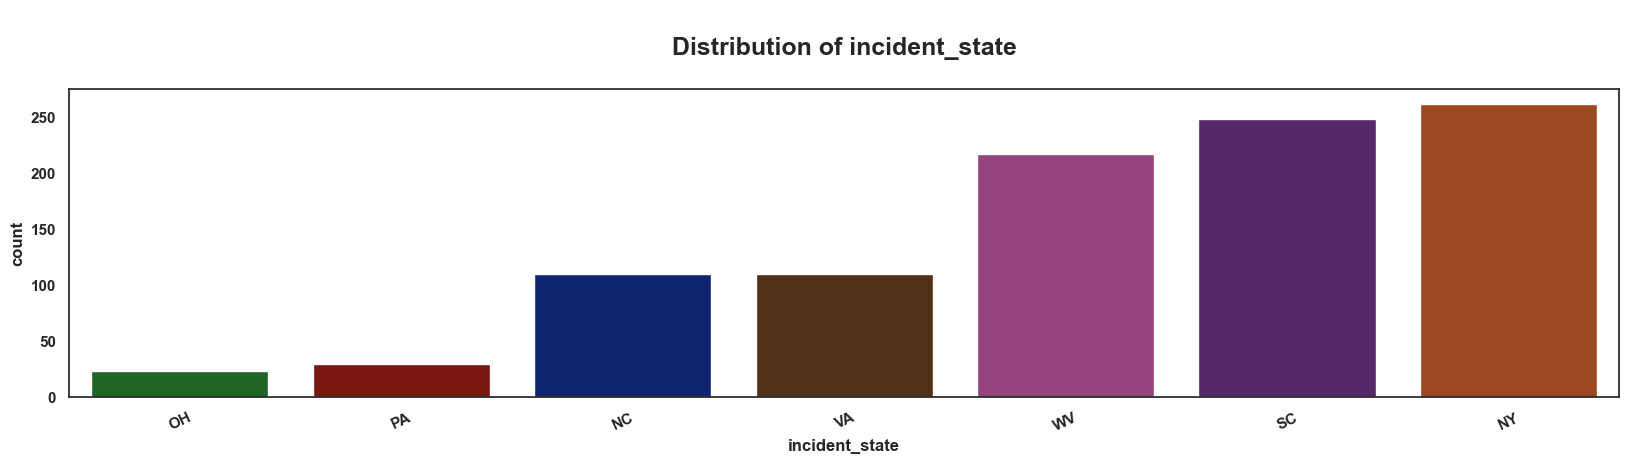

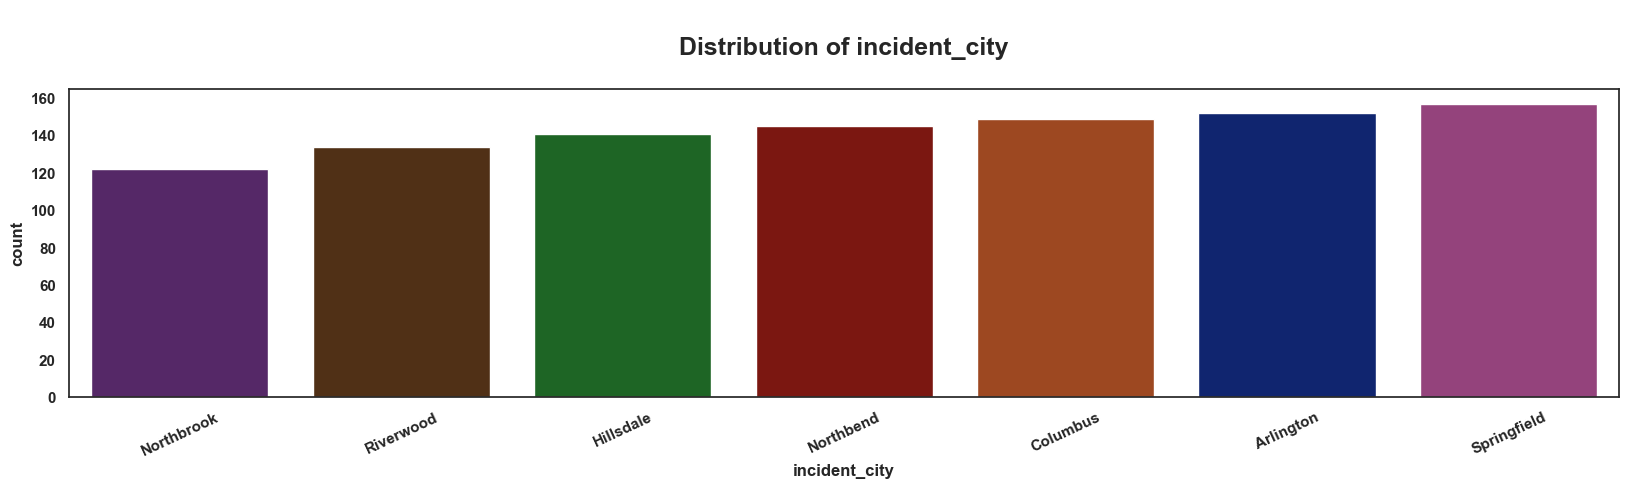

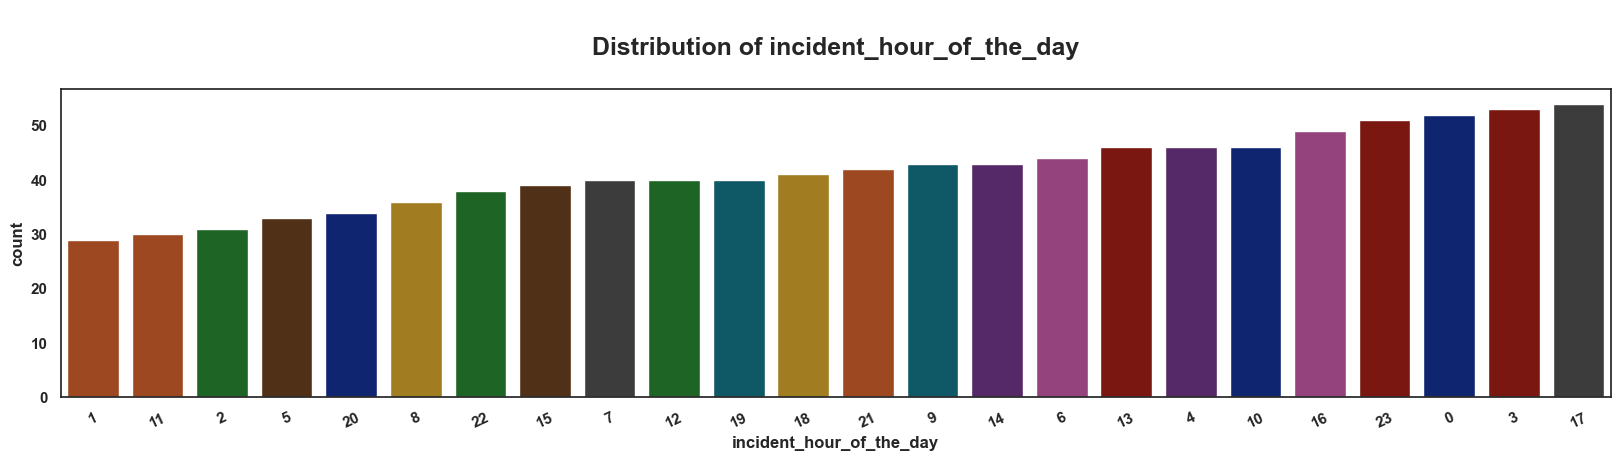

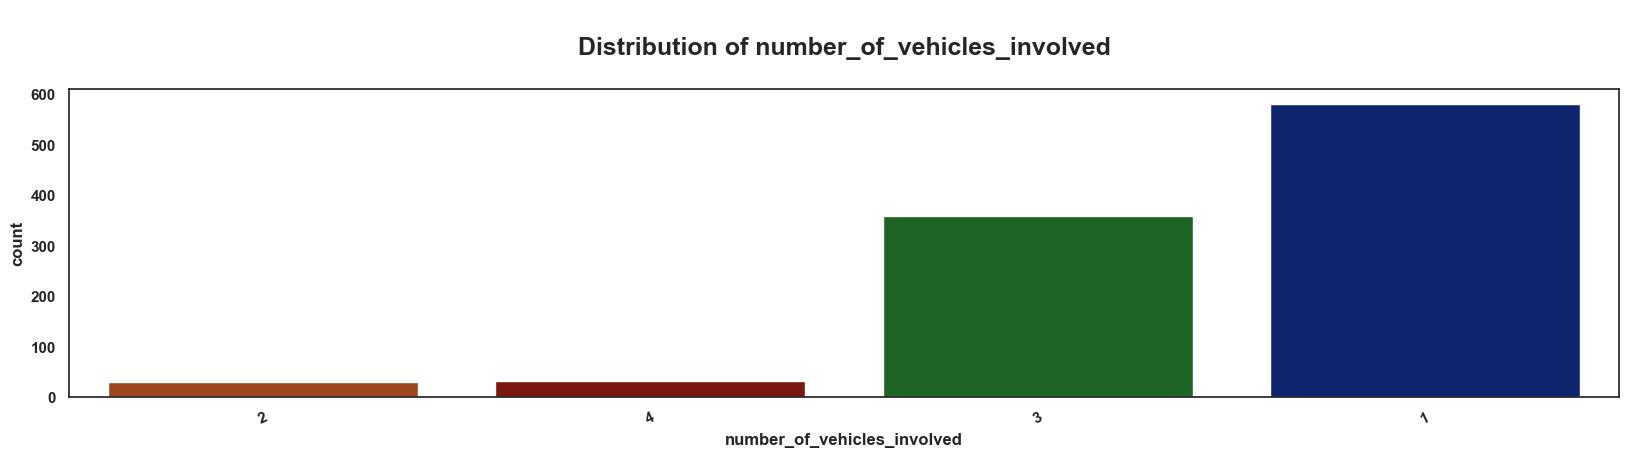

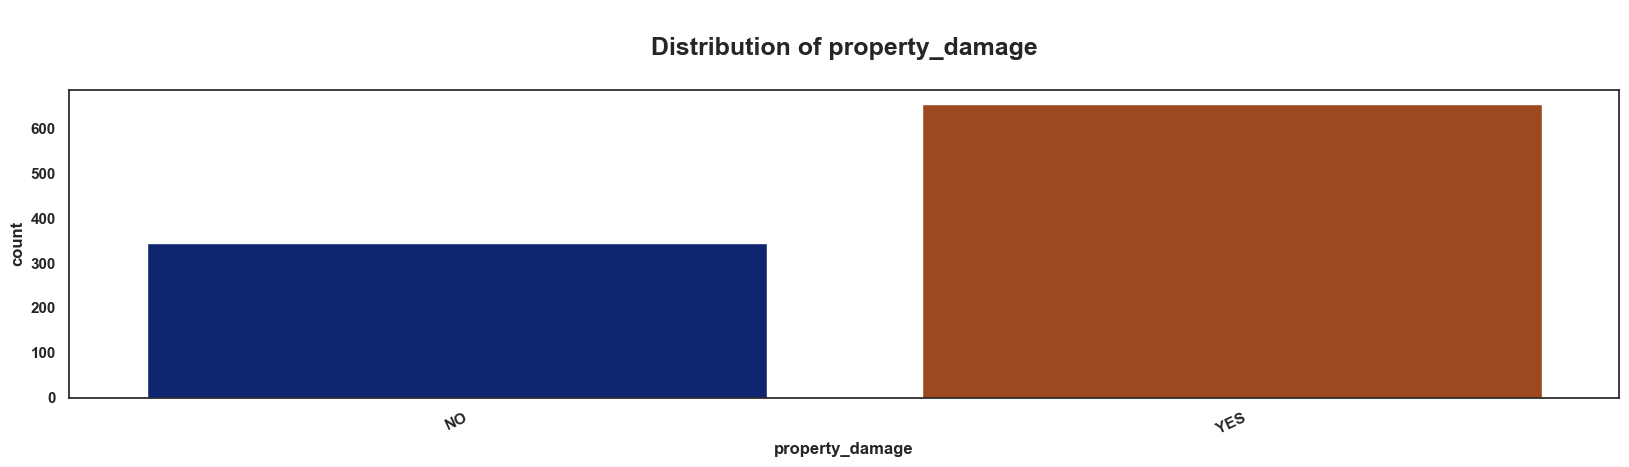

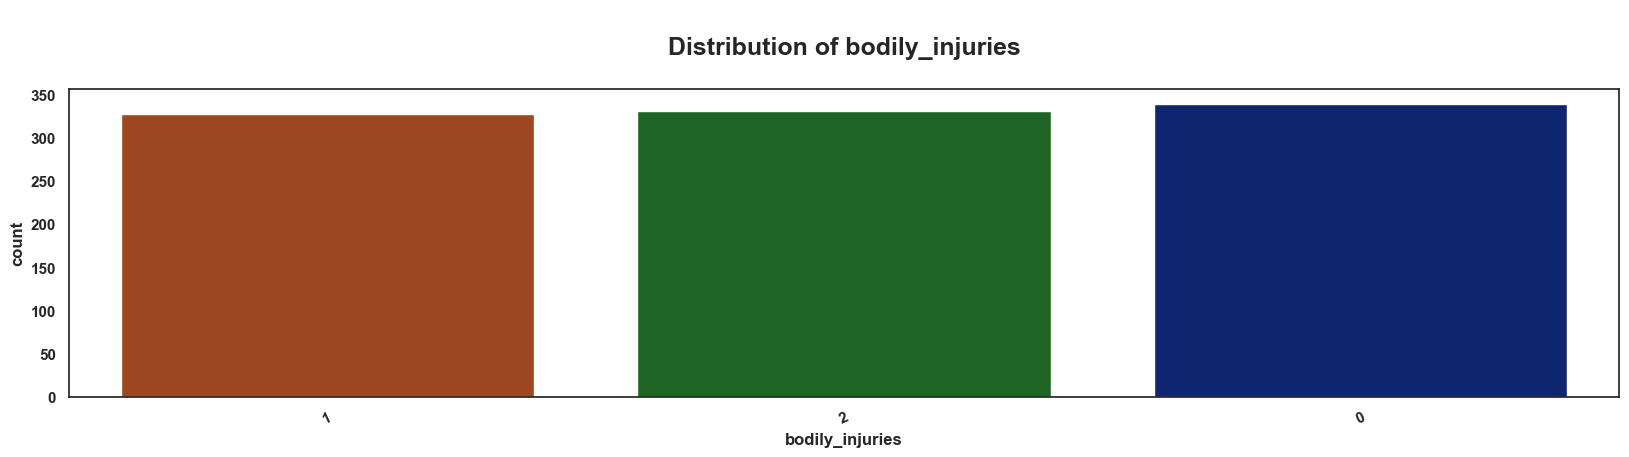

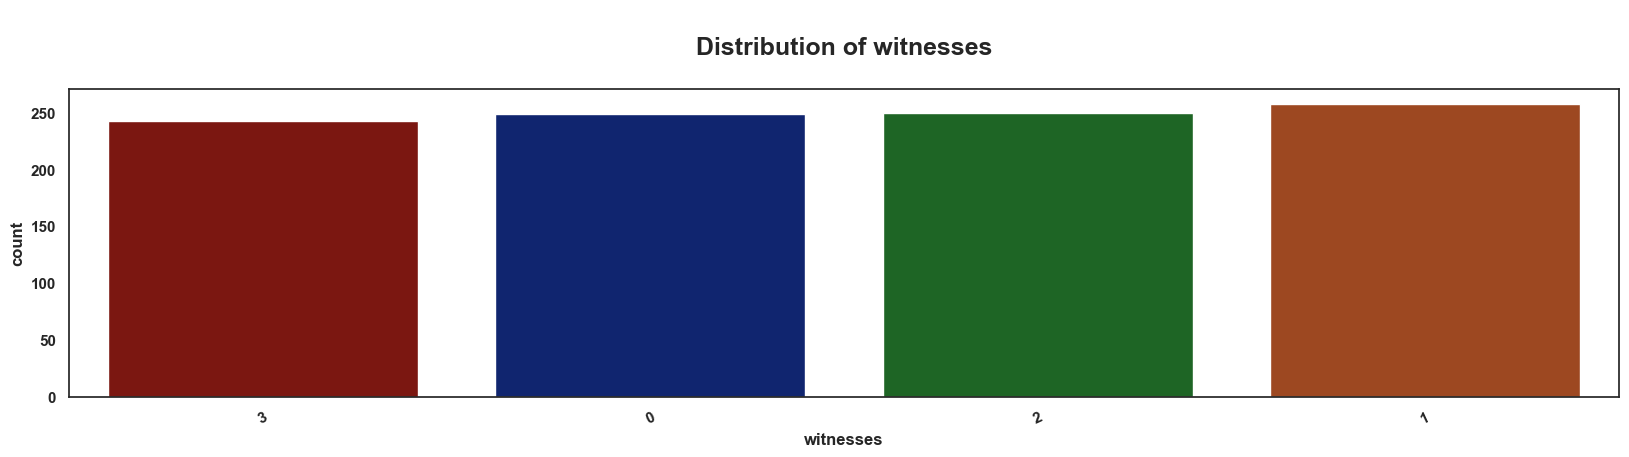

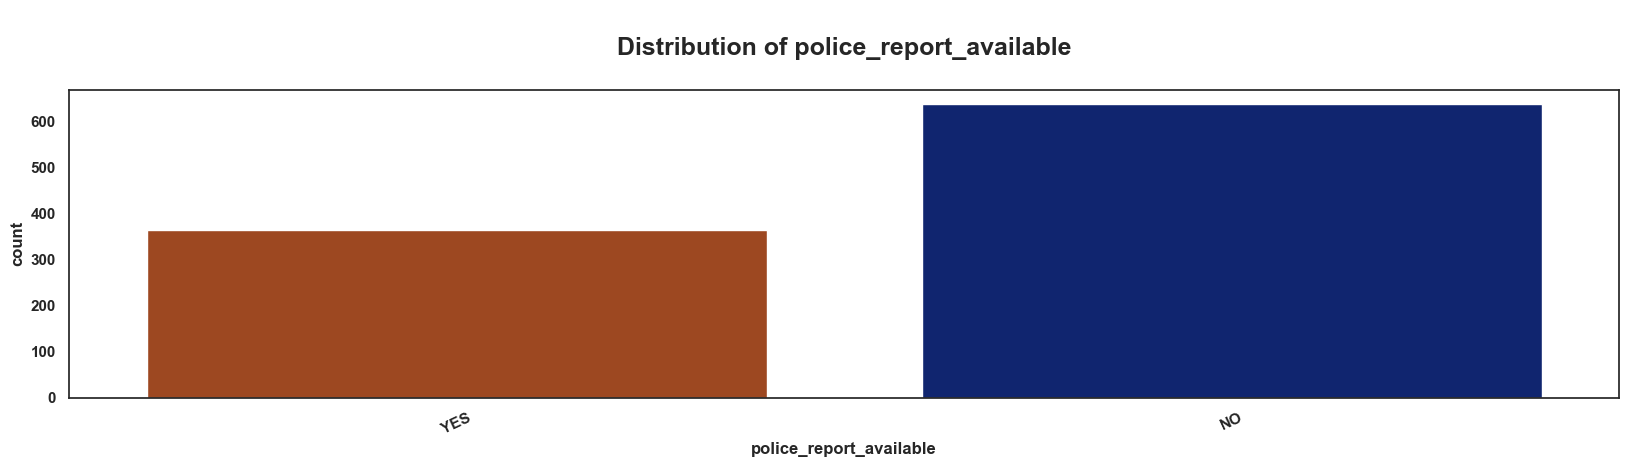

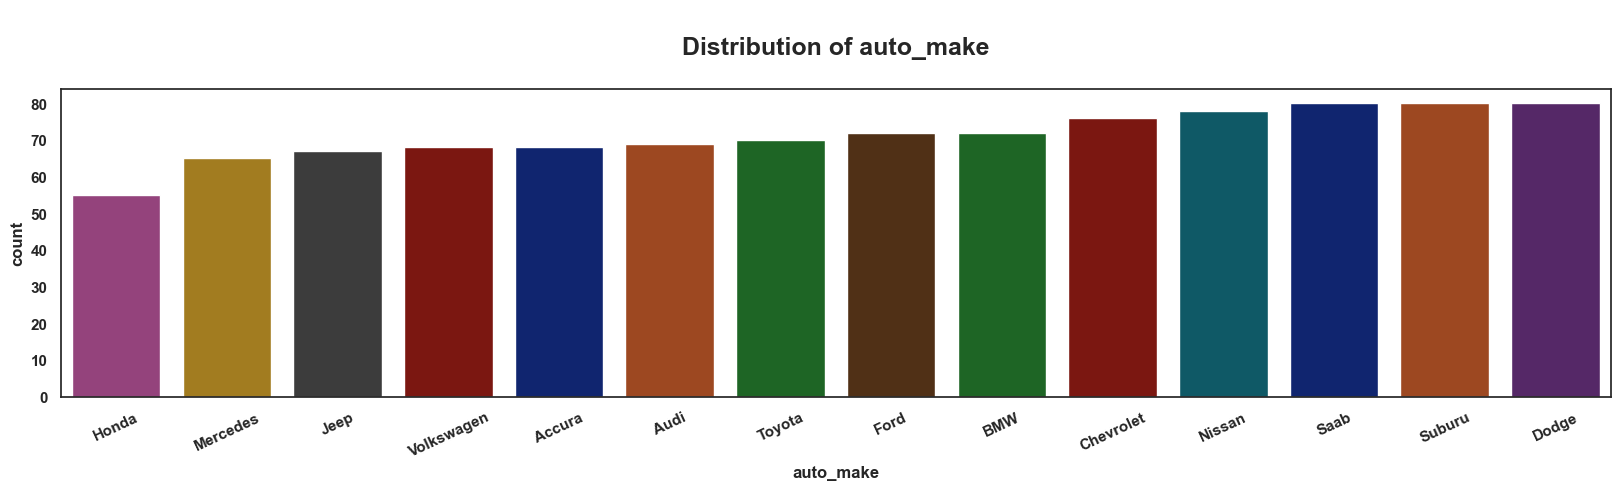

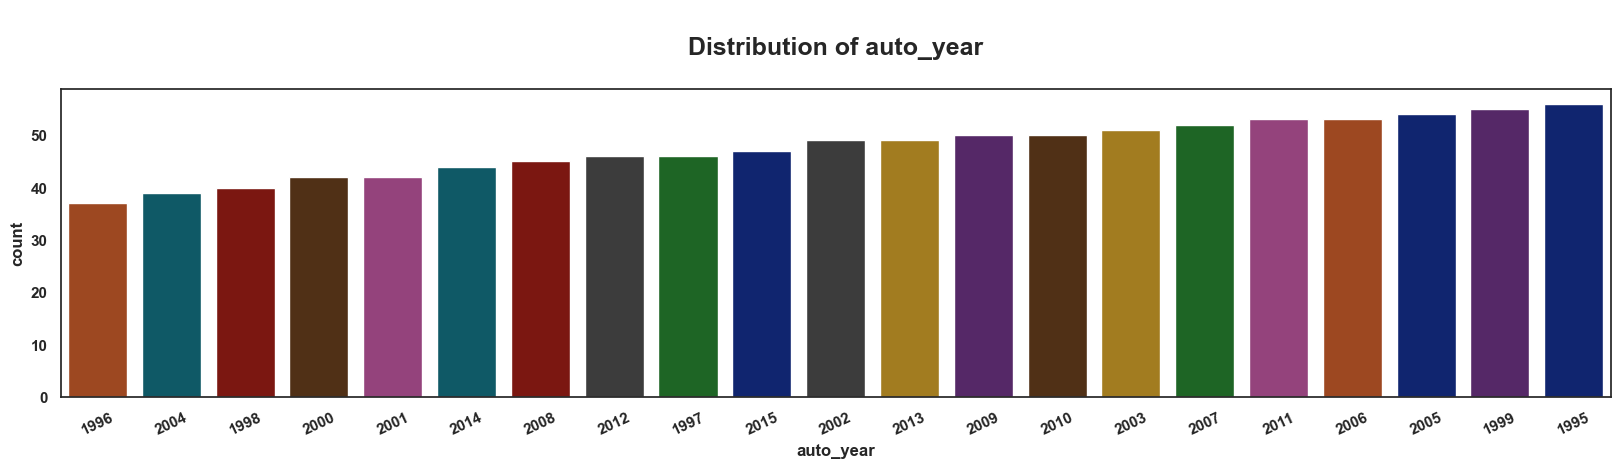

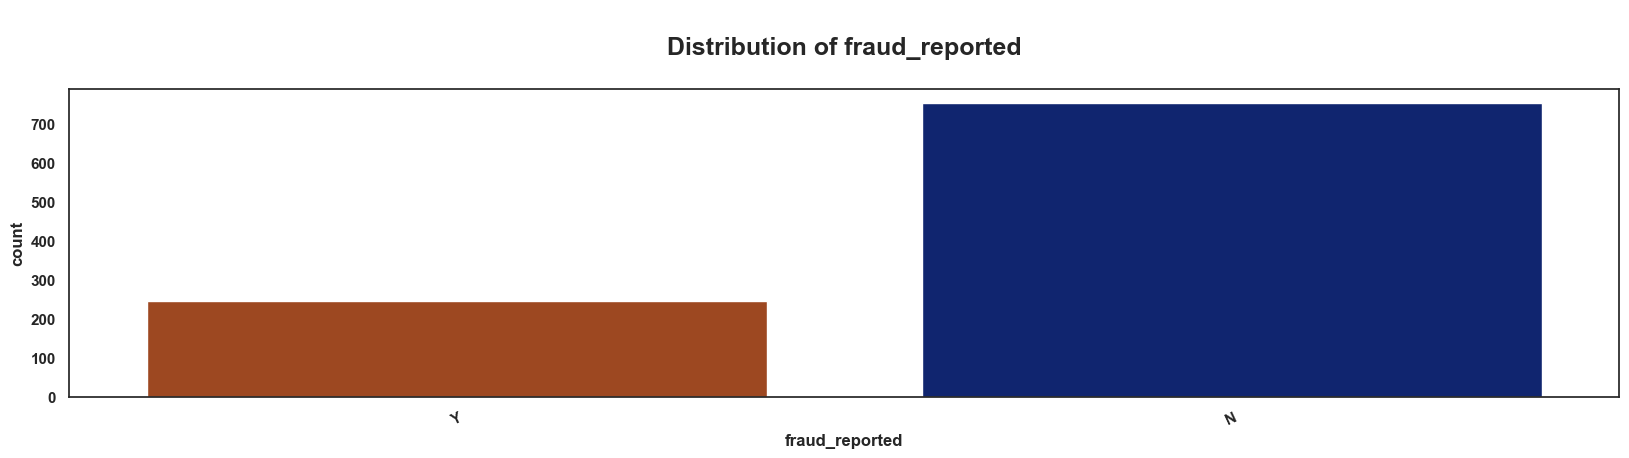

In [15]:
for i in categorical:
    plt.figure(figsize=(20, 4))
    sns.countplot(data=df, x=df[i], hue=i, order = df[i].value_counts().index.tolist()[::-1],palette='dark',legend=False)
    plt.title(f"\nDistribution of {i}\n",fontdict={'fontsize':18,'fontweight':'bold'})
    plt.xticks(rotation=25)
    plt.show()
    plt.close()

#### <span style="color:Khaki;"> Insights from Categorical Variables distribution:</span>

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Bank Accounts: -**</span>  Most people have 3 to 9 bank accounts.

   - <span style="color: Tomato;font-fa mily:calibri;font-size:130%">**Credit Cards: -**</span> Most people have 3 to 8 credit cards.
   
   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Loans -**</span> Most people have 2 to 4 loans.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Payment Behavior: -**</span> Most people pay the minimum due. This group is a key target for our problem statement (target people for the bank).

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Credit Scores: -**</span> Most people have a standard credit score, likely those who pay only the minimum dues.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Loan Enquiries: -**</span> The largest audience consists of people with low loan enquiries.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Age Distribution: -**</span> Most of the audience is aged between 36 and 50. There is a non-linear relationship observed, with minimal representation from those below 18 and above 50. The mid-age group constitutes the majority.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Payment Behaviour: -**</span> it has only one category so we can drop this column.

### <span style="color:Khaki;"> Relationship Numerical Variables VS Classification Target (Fraud):</span>

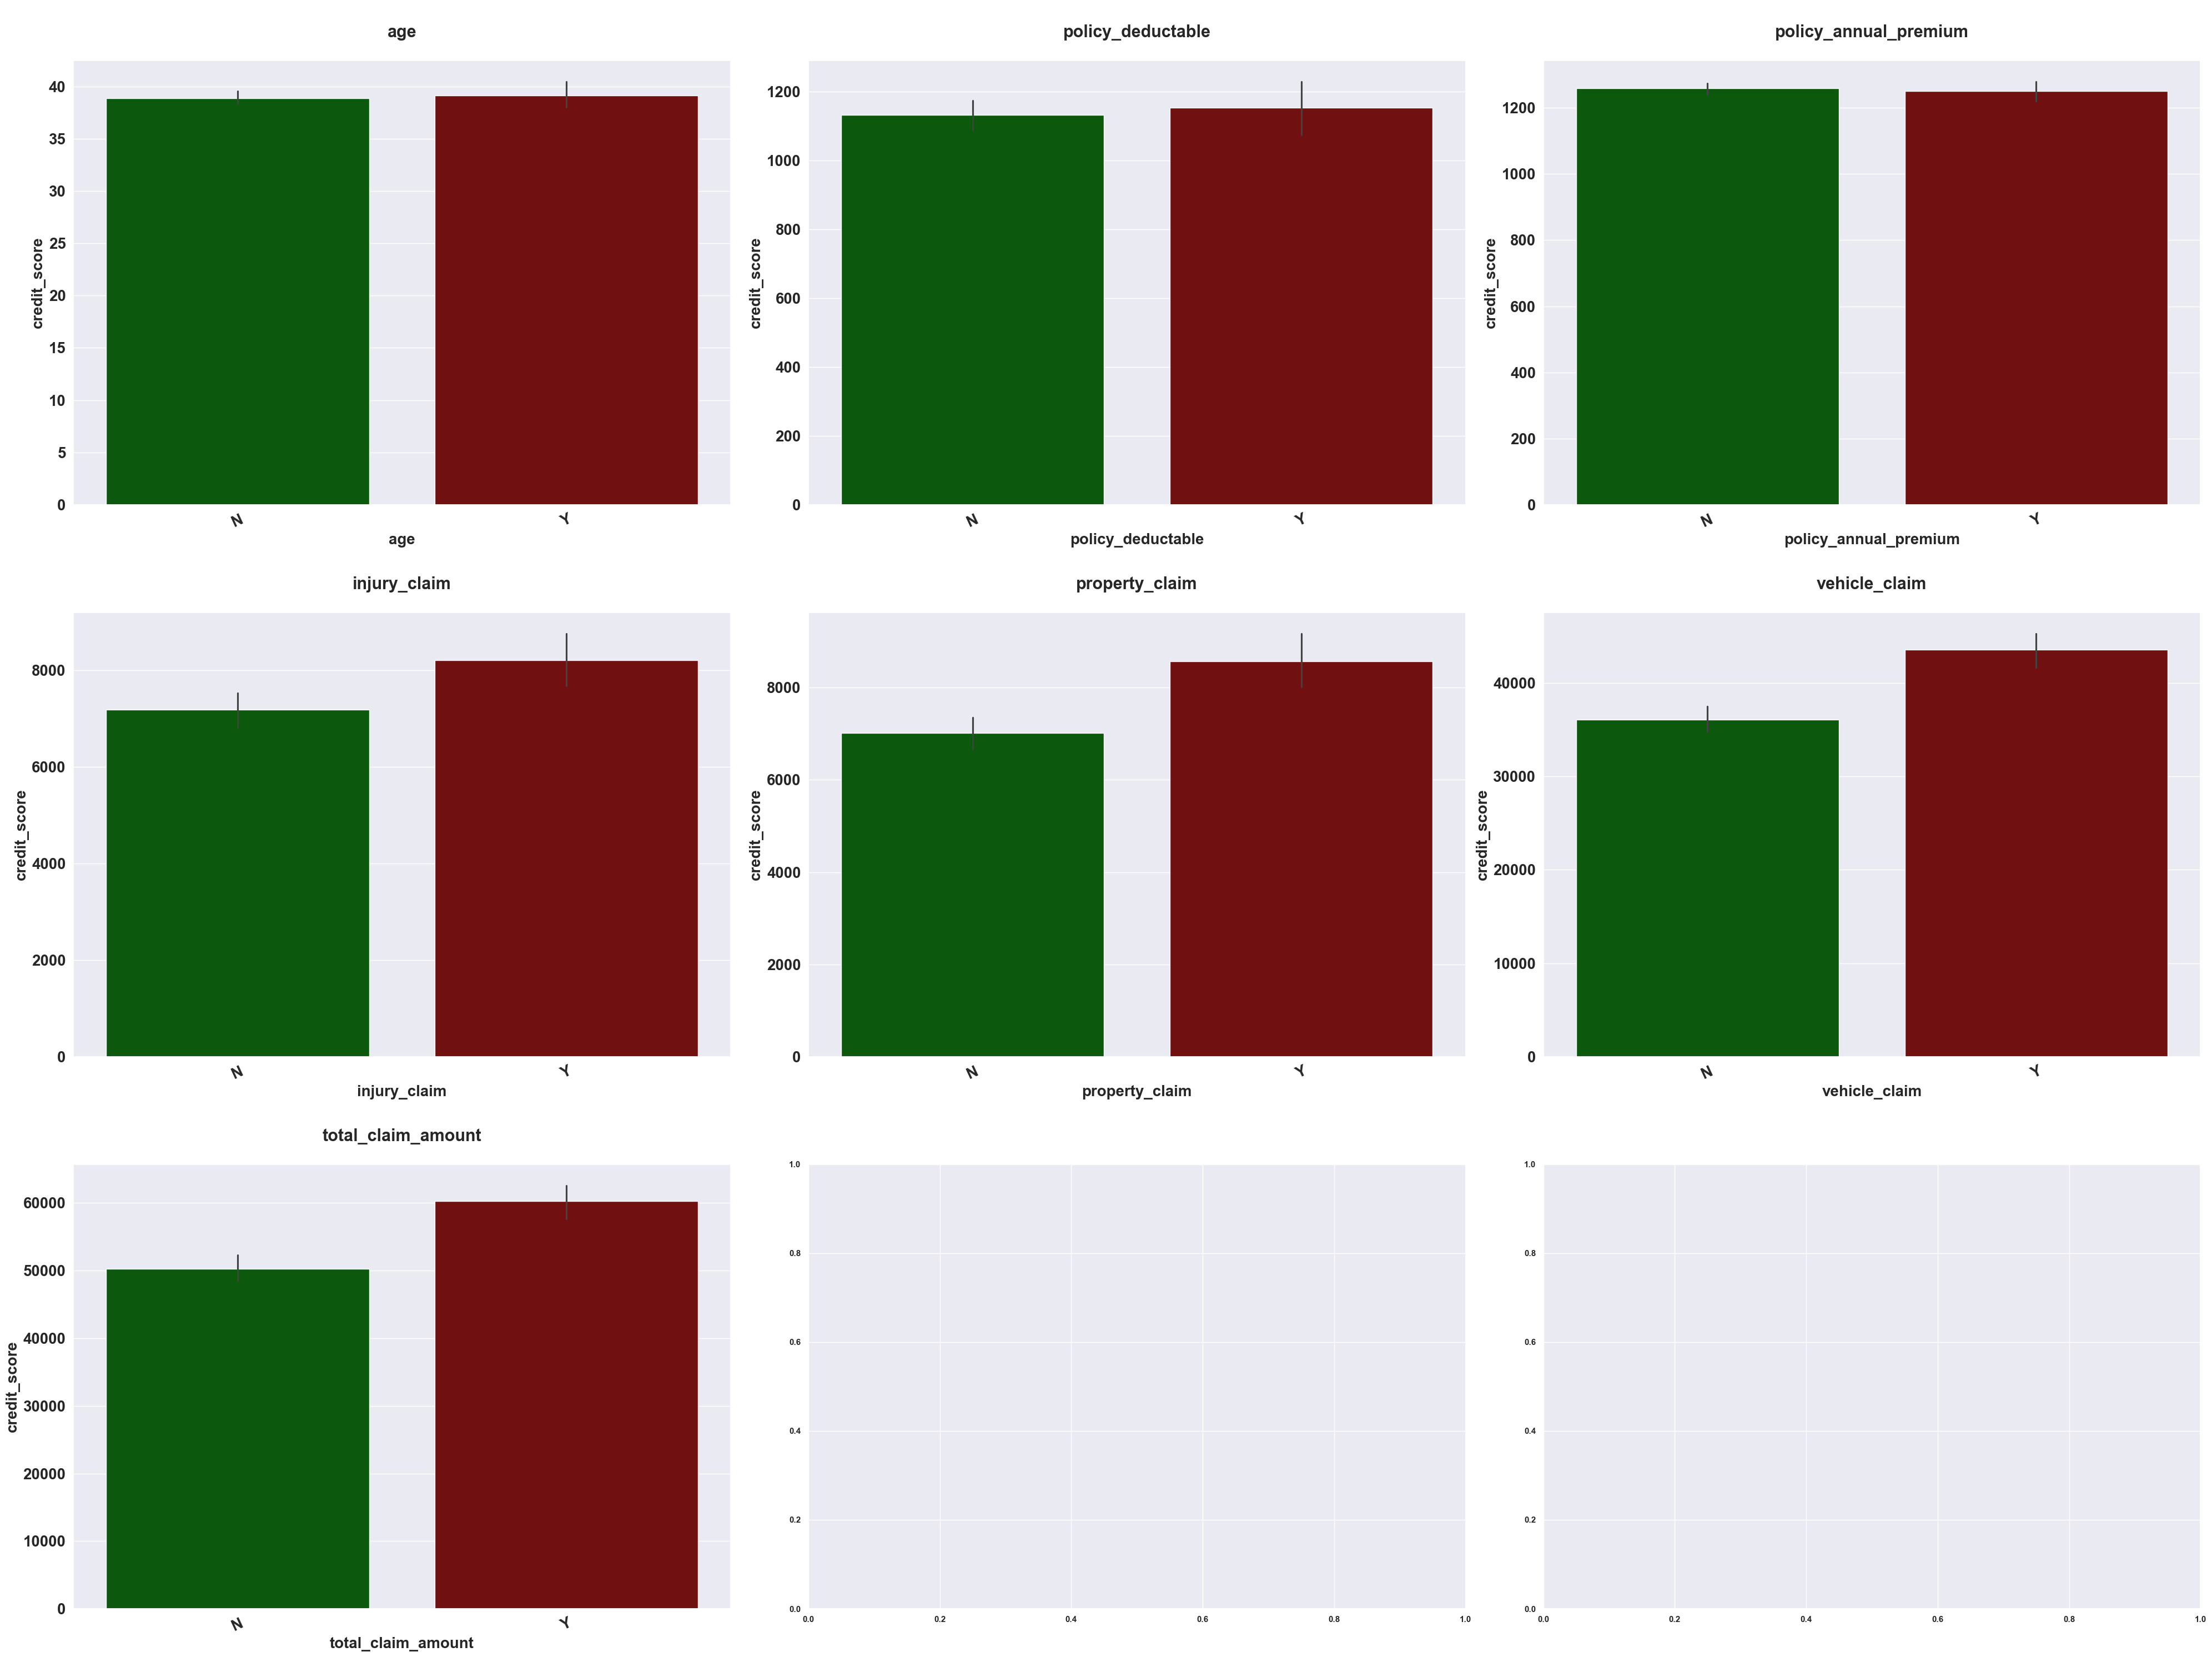

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [34]:
fig, axes = plt.subplots(ncols=3, nrows = int(np.ceil(len(continuous)/3)), figsize=(40, 30))


for i, col in enumerate(continuous):
    if i != 'fraud_reported':
        sns.barplot(data=df, y=col, x='fraud_reported', hue="fraud_reported",hue_order=['N','Y'],orient='v',palette=['DarkGreen','maroon'], legend=False,ax=axes[i//3, i%3])
        axes[i//3, i%3].set_title(col,fontdict={'fontsize':20,'fontweight':'bold'})
        axes[i//3, i%3].tick_params(axis='x', rotation=25)
        axes[i//3, i%3].set_title(f"\n{col}\n", weight='bold', fontsize=22)  # Explicitly set title font weight and size
        axes[i//3, i%3].tick_params(axis='x', rotation=25, labelsize=20)  # Set xtick label size
        axes[i//3, i%3].tick_params(axis='y', labelsize=20)  # Set ytick label size
        axes[i//3, i%3].set_xlabel(col, fontsize=20, weight='bold')  # Set xlabel size and weight
        axes[i//3, i%3].set_ylabel('credit_score', fontsize=20, weight='bold')  # Set ylabel size and weight
    plt.close
plt.tight_layout()
plt.show()
plt.close

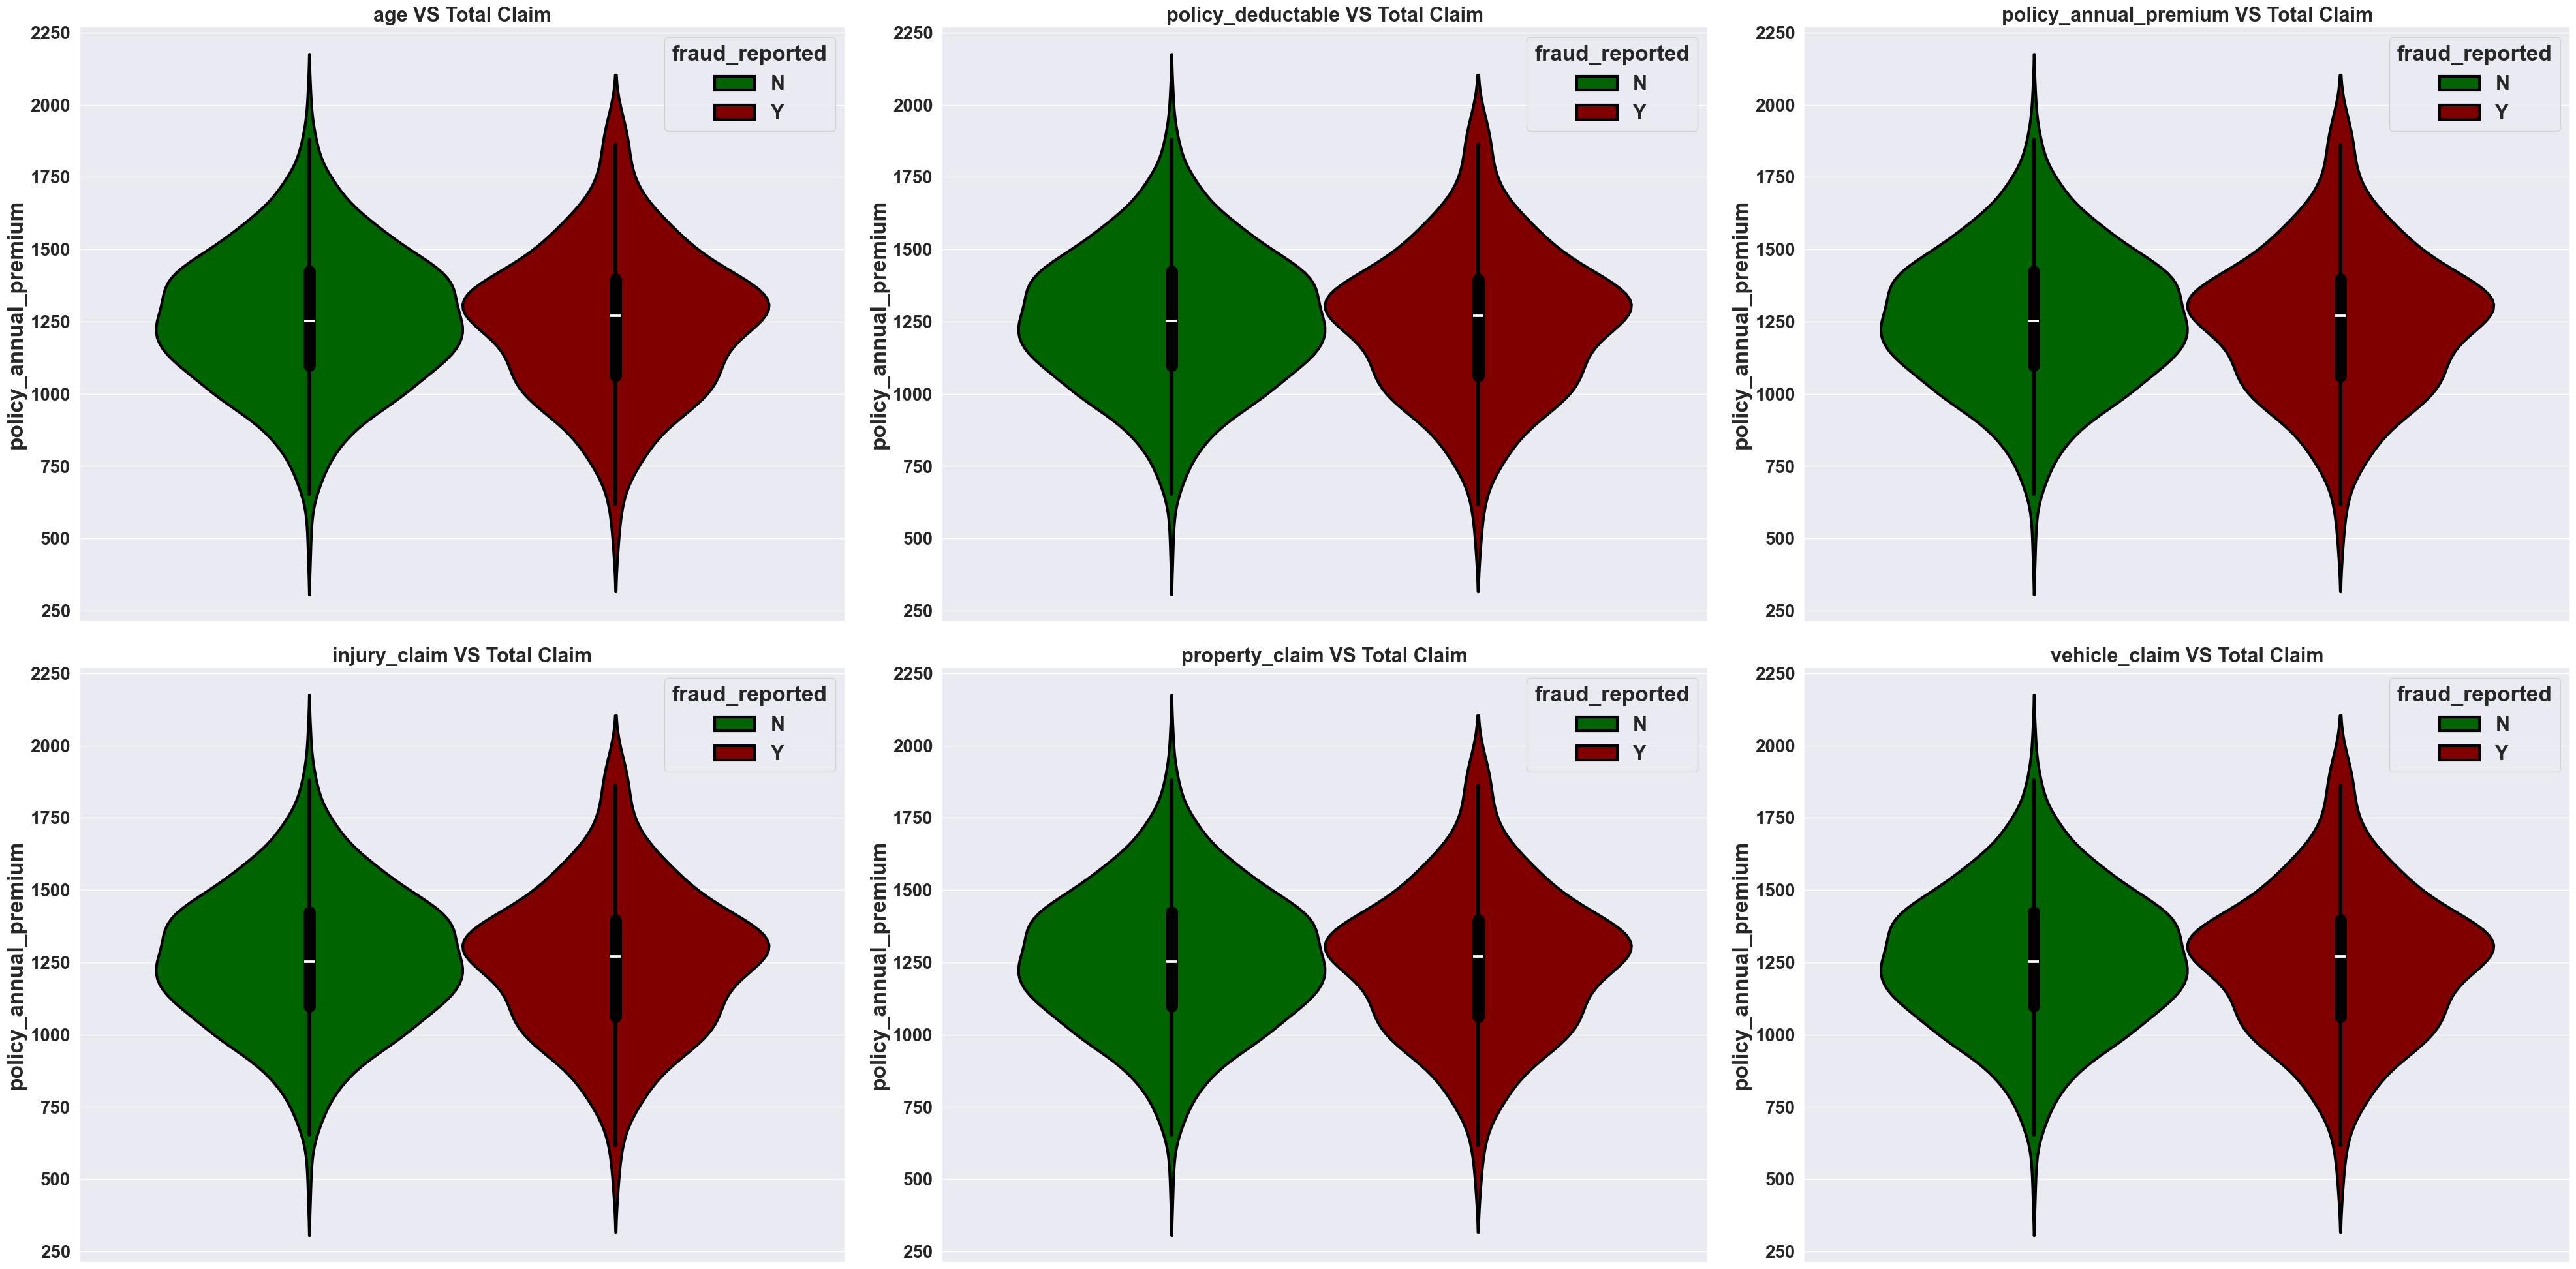

In [ ]:
sns.set_theme(font_scale=2)

continuous.remove('total_claim_amount')


fig, axes = plt.subplots(ncols=3, nrows = int(np.ceil((len(continuous))/3)), figsize=(40, 20))

for i, col in enumerate(continuous):

        sns.violinplot(data=df,y='policy_annual_premium',hue='fraud_reported',hue_order=['N','Y'],palette=['darkgreen','maroon'],saturation=1,
                linewidth=3,linecolor='#000000',ax=axes[i//3, i%3]).set_title(f'{col} VS Total Claim',weight='bold', fontsize=22)
        axes[i//3, i%3].tick_params(axis='x', rotation=25, labelsize=20)  # Set xtick label size
        axes[i//3, i%3].tick_params(axis='y', labelsize=20)  # Set ytick label size
    
plt.tight_layout()
plt.show()
plt.close
sns.set_theme(font_scale=1)
continuous.append('total_claim_amount')

### <span style="color:Khaki;"> Relationship Categorical Variables VS Classification Target (Fraud):</span>

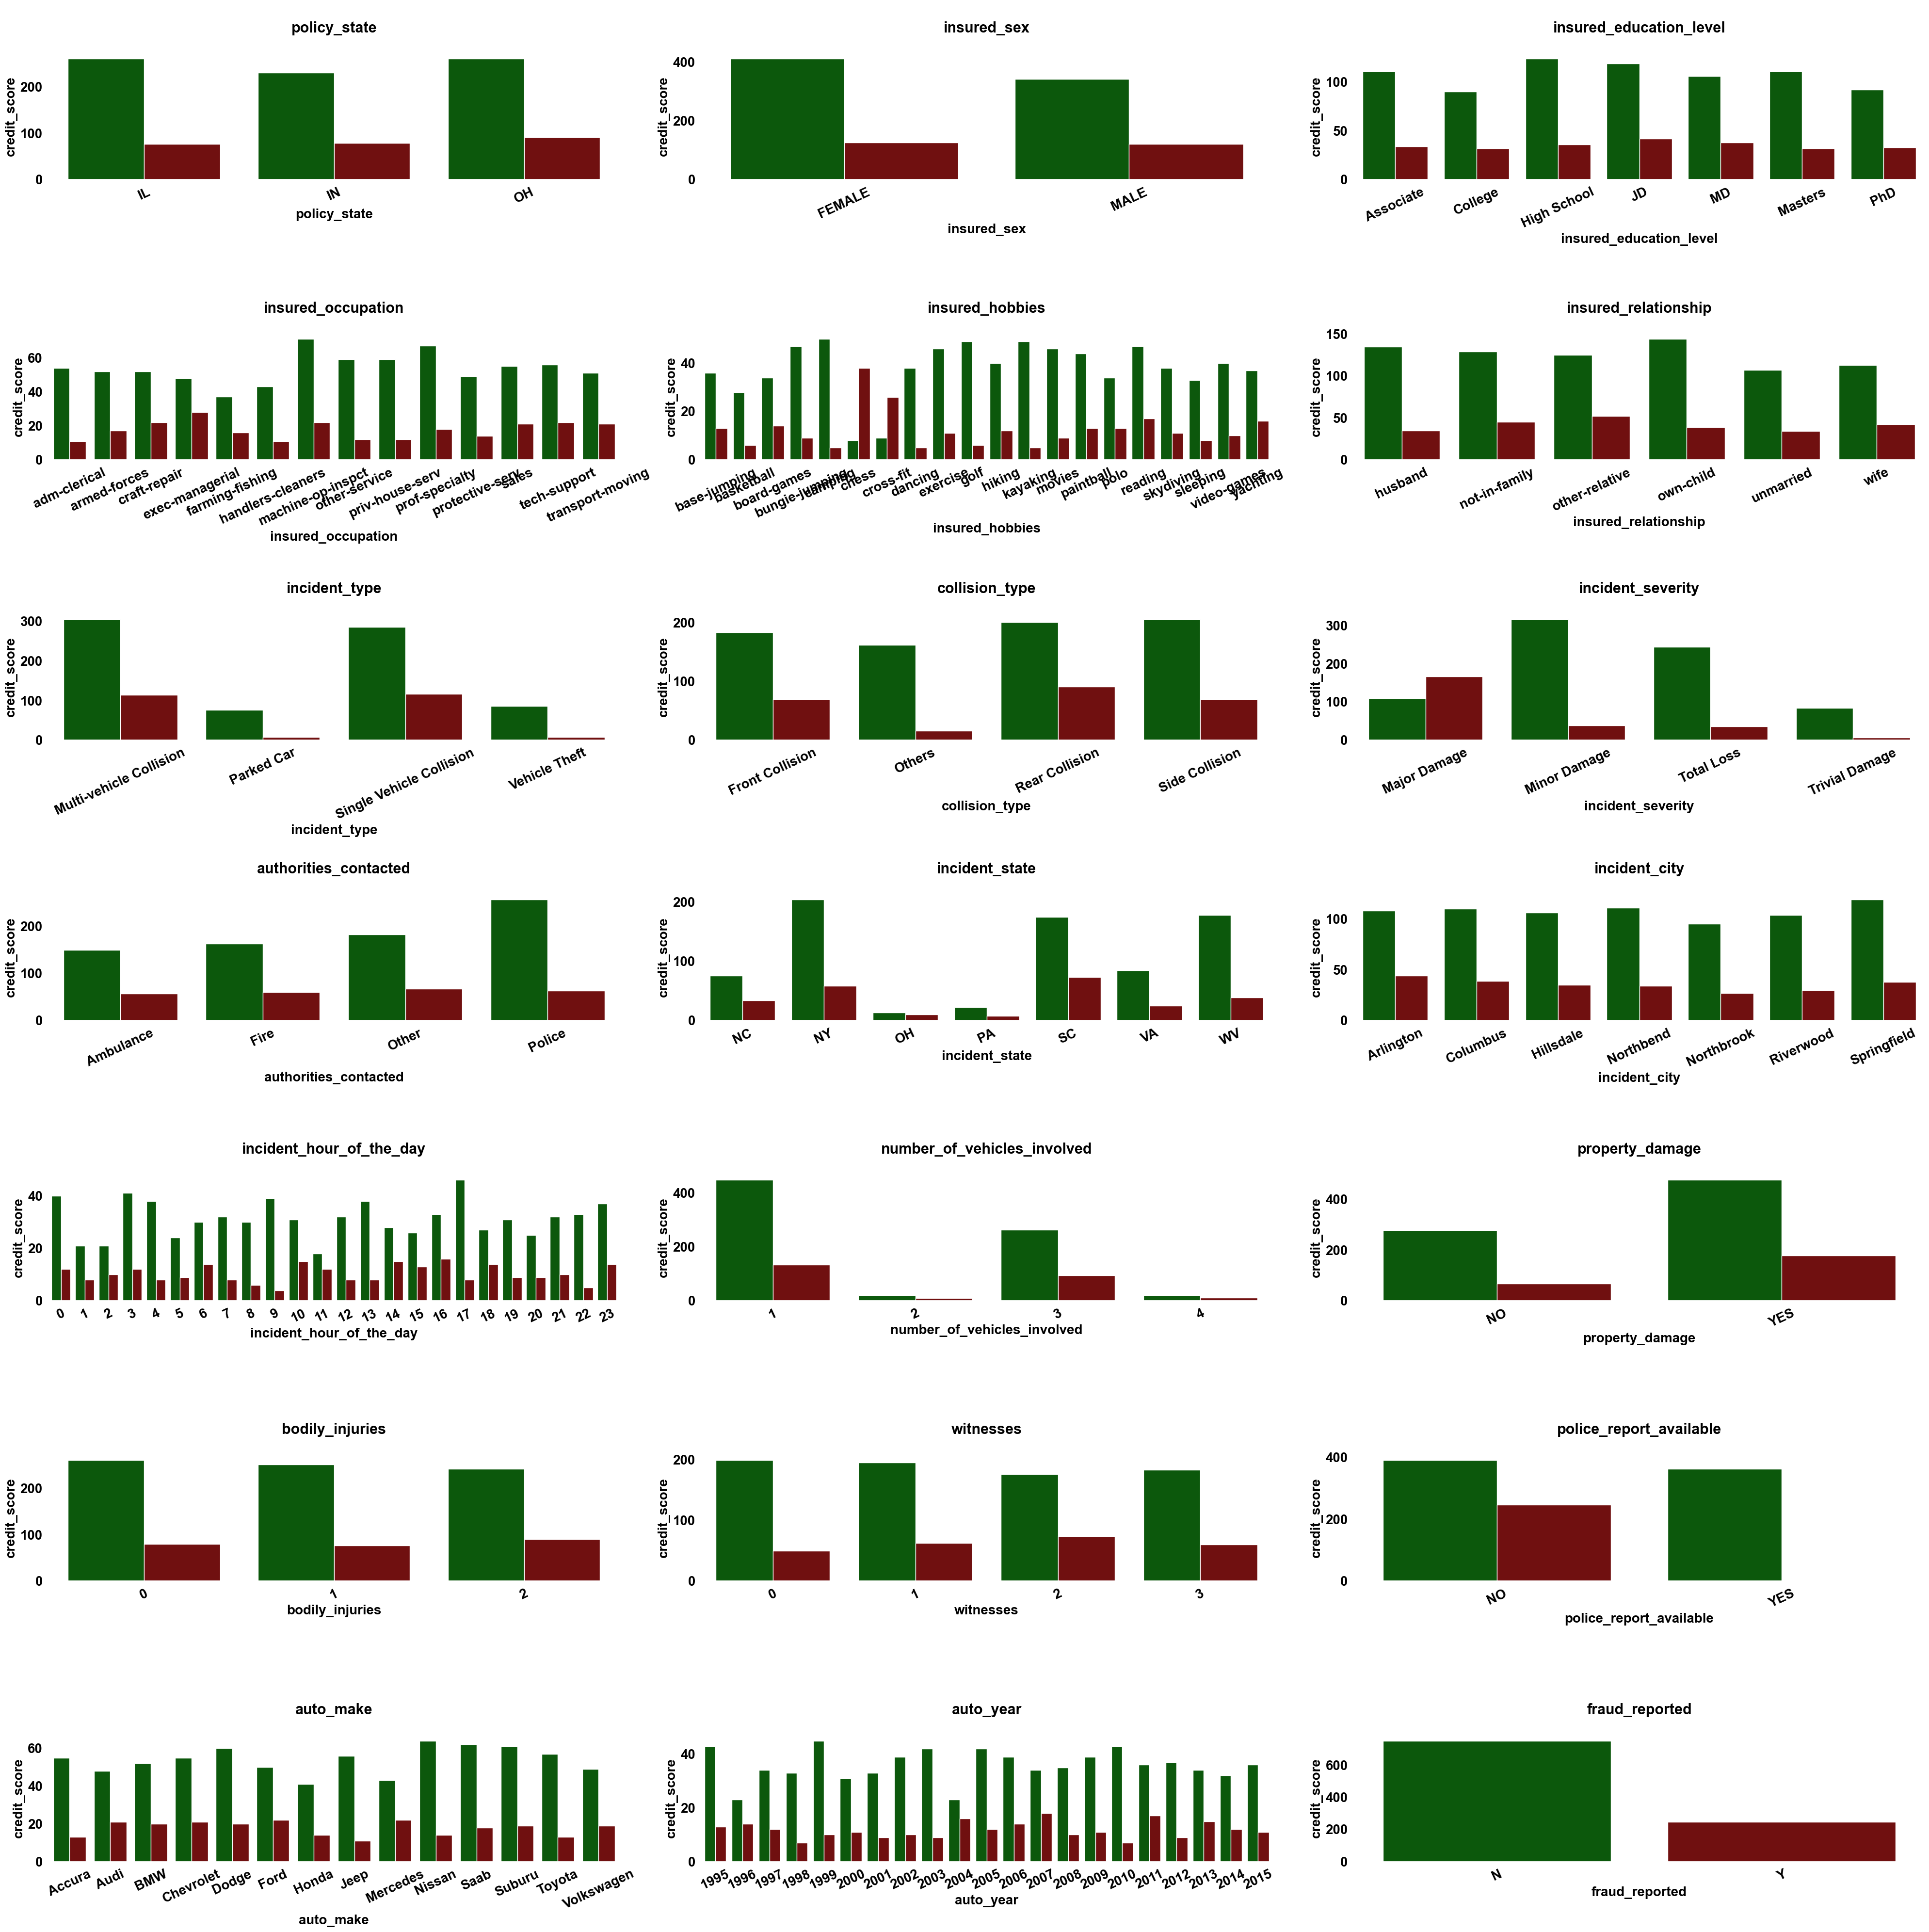

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows = int(np.ceil(len(categorical)/3)), figsize=(40, 40))

for i, col in enumerate(categorical):
    if i != 'fraud_reported':
        sns.countplot(data=df, x=col, hue="fraud_reported",hue_order=['N','Y'],palette=['darkgreen','maroon'], legend=False,ax=axes[i//3, i%3])
        axes[i//3, i%3].set_title(f"\n{col}\n", weight='bold', fontsize=22)  # Explicitly set title font weight and size
        axes[i//3, i%3].tick_params(axis='x', rotation=25, labelsize=20)  # Set xtick label size
        axes[i//3, i%3].tick_params(axis='y', labelsize=20)  # Set ytick label size
        axes[i//3, i%3].set_xlabel(col, fontsize=20, weight='bold')  # Set xlabel size and weight
        axes[i//3, i%3].set_ylabel('credit_score', fontsize=20, weight='bold')  # Set ylabel size and weight

plt.tight_layout()
plt.show()

### <span style="color:Khaki;"> Relationship Numerical Variables VS Regression Target (Policy Annual Premium):</span>

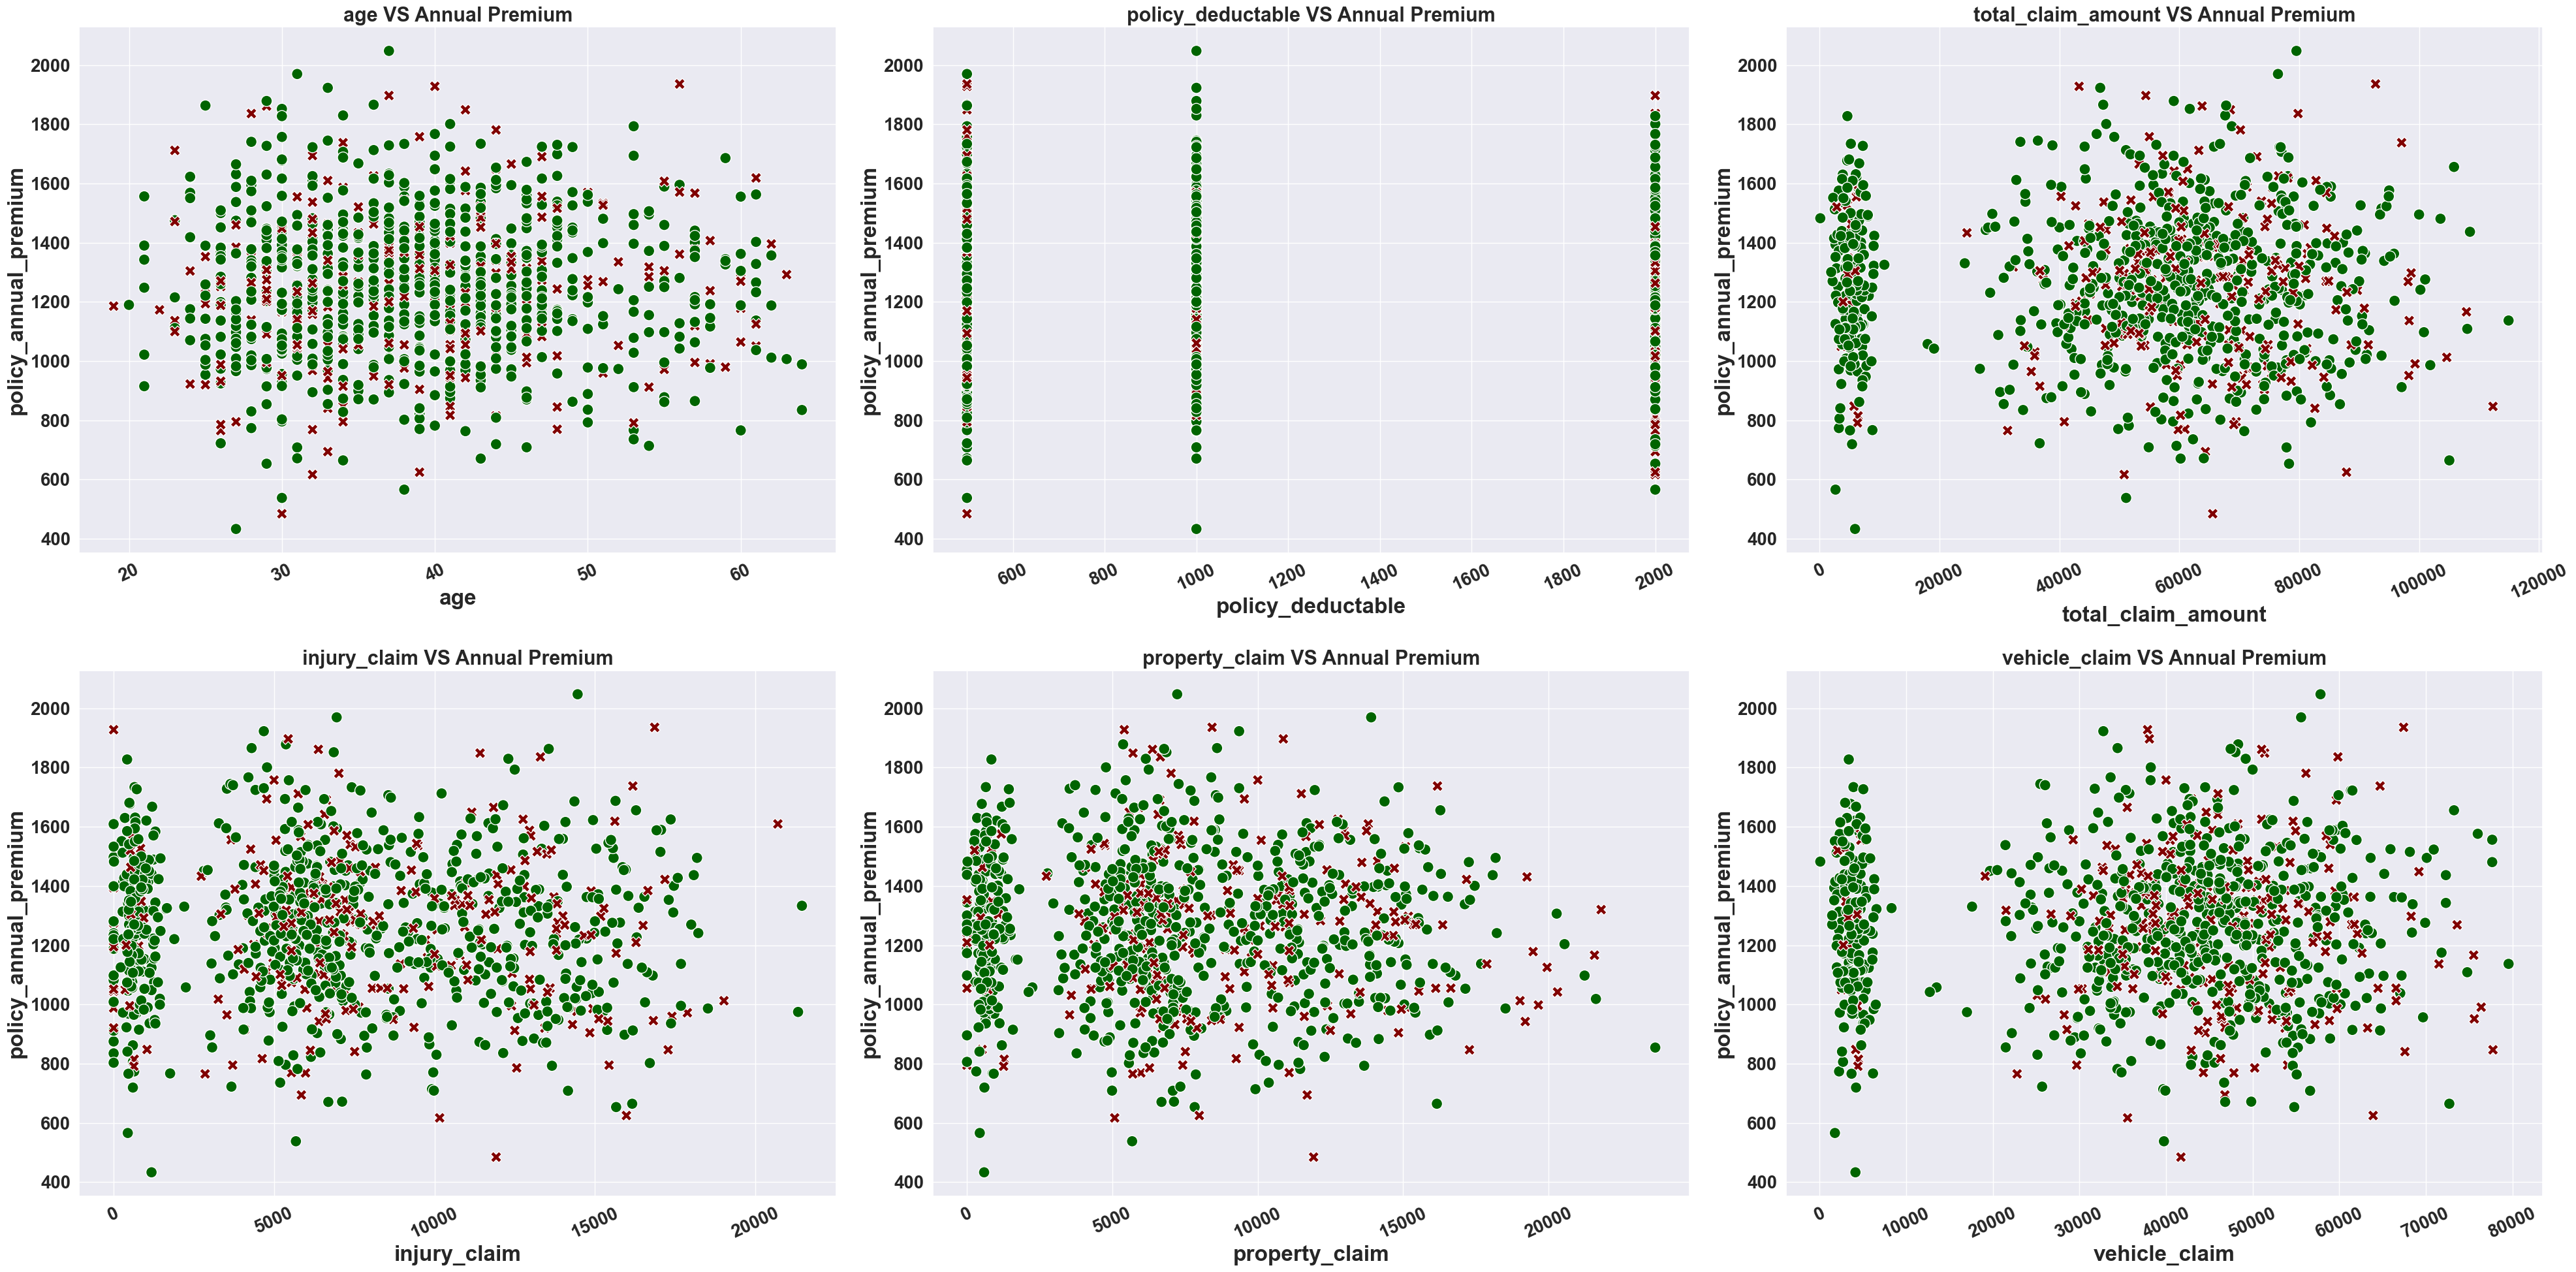

In [15]:
sns.set_theme(font_scale=2)

continuous.remove('policy_annual_premium')
fig, axes = plt.subplots(ncols=3, nrows = int(np.ceil((len(continuous))/3)), figsize=(40, 20))

for i, col in enumerate(continuous):
    sns.scatterplot(data=df,x=col,y='policy_annual_premium',hue='fraud_reported',hue_order=['N','Y'],palette=['darkgreen','maroon'],legend=False,style='fraud_reported',
           s=150, ax=axes[i//3, i%3]).set_title(f'{col} VS Annual Premium',weight='bold', fontsize=22)
    axes[i//3, i%3].tick_params(axis='x', rotation=25, labelsize=20)  # Set xtick label size
    axes[i//3, i%3].tick_params(axis='y', labelsize=20)  # Set ytick label size
    
plt.tight_layout()
plt.show()
plt.close
sns.set_theme(font_scale=1)
continuous.append('policy_annual_premium')

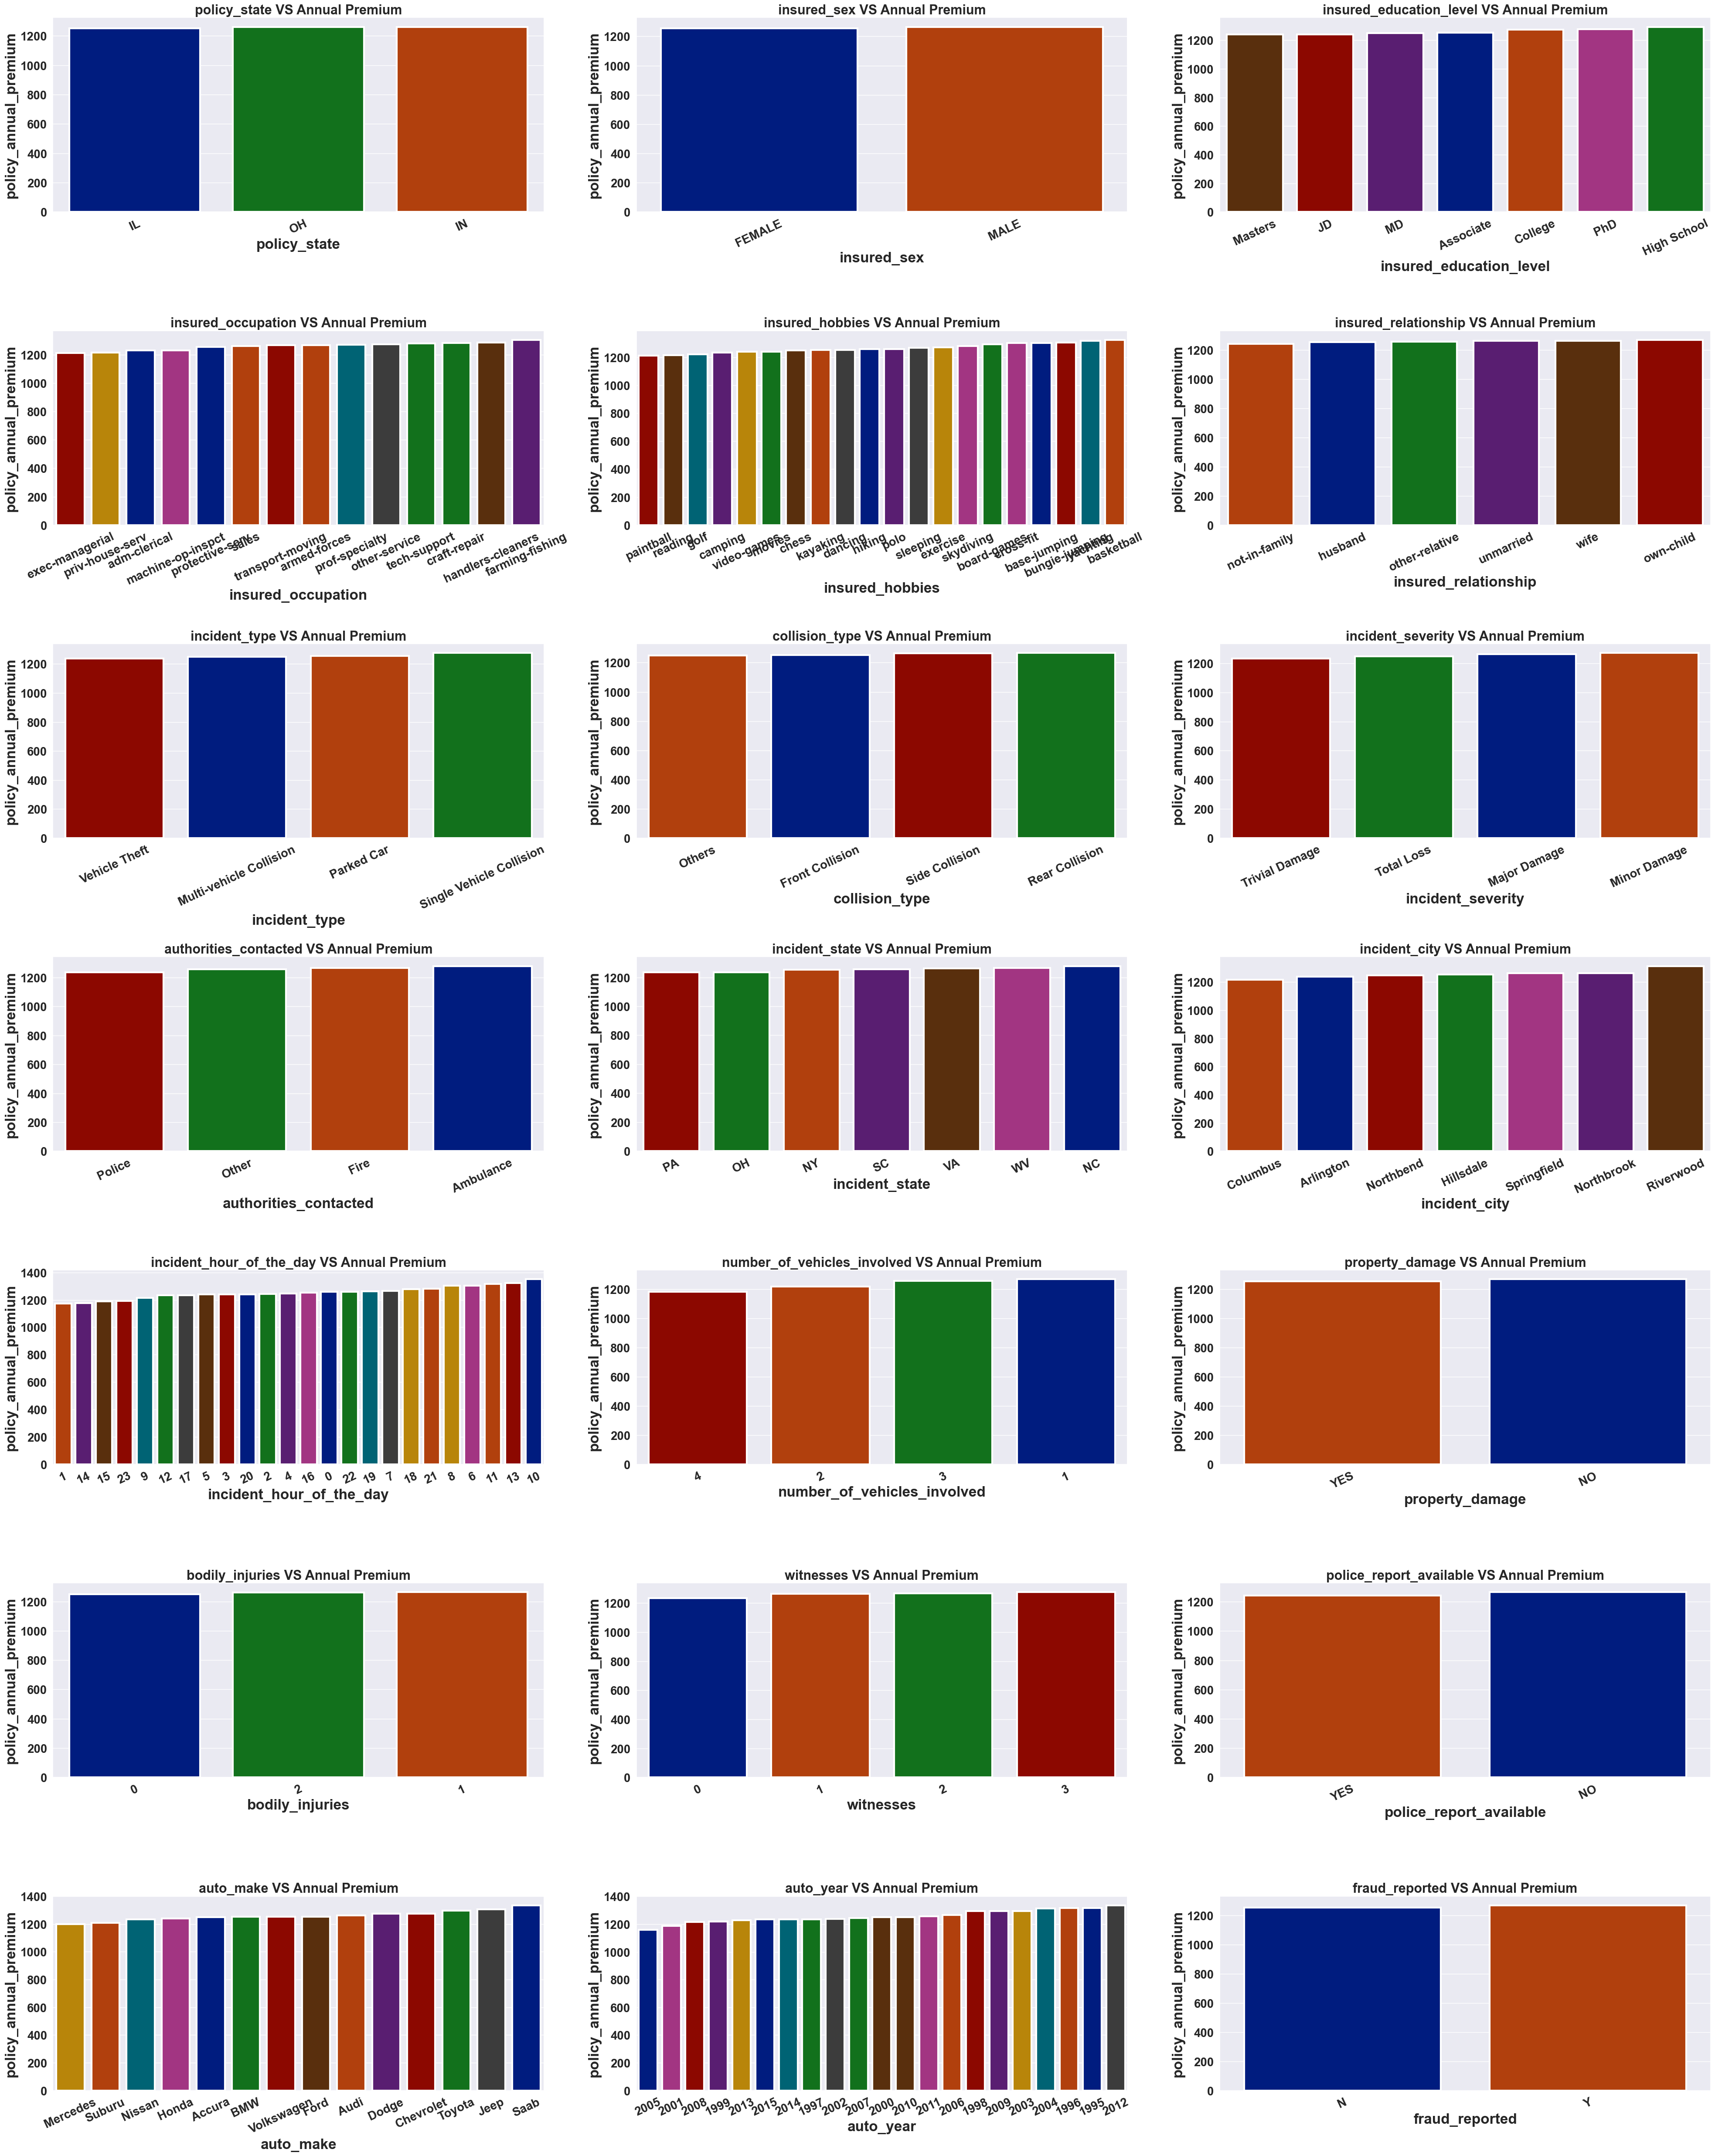

In [ ]:
sns.set_theme(font_scale=2)


fig, axes = plt.subplots(ncols=3, nrows = int(np.ceil((len(categorical))/3)), figsize=(40, 50))

for i, col in enumerate(categorical):
    dff = df.groupby(col,observed=False,as_index=True)['policy_annual_premium'].median().reset_index().sort_values('policy_annual_premium')

    sns.barplot(data=dff,x=col,y='policy_annual_premium',hue=col,palette='dark',order=dff[col],saturation=1,legend=False,
            linewidth=3,ax=axes[i//3, i%3]).set_title(f'{col} VS Annual Premium',weight='bold', fontsize=22)
    axes[i//3, i%3].tick_params(axis='x', rotation=25, labelsize=20)  # Set xtick label size
    axes[i//3, i%3].tick_params(axis='y', labelsize=20)  # Set ytick label size
    
plt.tight_layout()
plt.show()
plt.close
sns.set_theme(font_scale=1)


#### <span style="color:Khaki;"> Insights from Continuous Variables in relation with Credit Score:</span>

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Income: -**</span>  Higher income is generally associated with better credit scores, while lower income tends to be associated with poorer credit scores.

   - <span style="color: Tomato;font-fa mily:calibri;font-size:130%">**Outstanding Debt: -**</span> Individuals with lower outstanding debt typically have better credit scores compared to those with higher outstanding debt.
   
   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Credit Utilization -**</span> Higher credit utilization is generally linked to higher credit scores, while lower credit utilization tends to be associated with lower credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Credit History: -**</span> A longer credit history is often associated with better credit scores, while a shorter credit history tends to be associated with poorer credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Total EMI per Month: -**</span> The relationship between total EMI per month and credit score seems complex and might be influenced by income level. Higher EMIs are not necessarily indicative of better or worse credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Investment: -**</span> Individuals with higher investment amounts tend to have better credit scores compared to those with lower investment amounts.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Monthly Balance: -**</span> Maintaining a higher monthly balance is generally associated with better credit scores, while lower balances tend to be associated with poorer credit scores.
   
   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Credit Utilization Ratio: -**</span> This seems to have a strong positive correlation with credit score.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Debt Income Ratio: -**</span> A lower debt-to-income ratio is generally associated with better credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Loan Income Ratio: -**</span> A lower loan-to-income ratio is generally associated with better credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Interest Rate: -**</span>  While the relationship is less clear, there might be a slight tendency for lower interest rates to be associated with better credit scores.

   - <span style="color: Tomato;font-fa mily:calibri;font-size:130%">**Delayed Payment Ratio: -**</span> This seems to have a strong negative correlation with credit score.
   
   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Investment to Income Ratio -**</span> A higher investment-to-income ratio is generally associated with better credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Credit Utilization to Income Ratio: -**</span> A lower credit utilization-to-income ratio is generally associated with better credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Savings Rate: -**</span> A higher savings rate is generally associated with better credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Disposable Income: -**</span> A higher disposable income is generally associated with better credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Debt Paytime: -**</span> A shorter debt pay time is generally associated with better credit scores.
   
   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Reliable Payment: -**</span> A higher reliable payment score is generally associated with better credit scores.

### <span style="color:Khaki;"> Credit Scores Based on Annual Income:</span>

In [12]:
df.columns

Index(['months_as_customer', 'age', 'policy_bind_date', 'policy_state',
       'policy_deductable', 'policy_annual_premium', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_date', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'incident_state', 'incident_city', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_year', 'fraud_reported'],
      dtype='object')

Text(0.5, 1.0, 'Credit Scores Based on Annual Income')

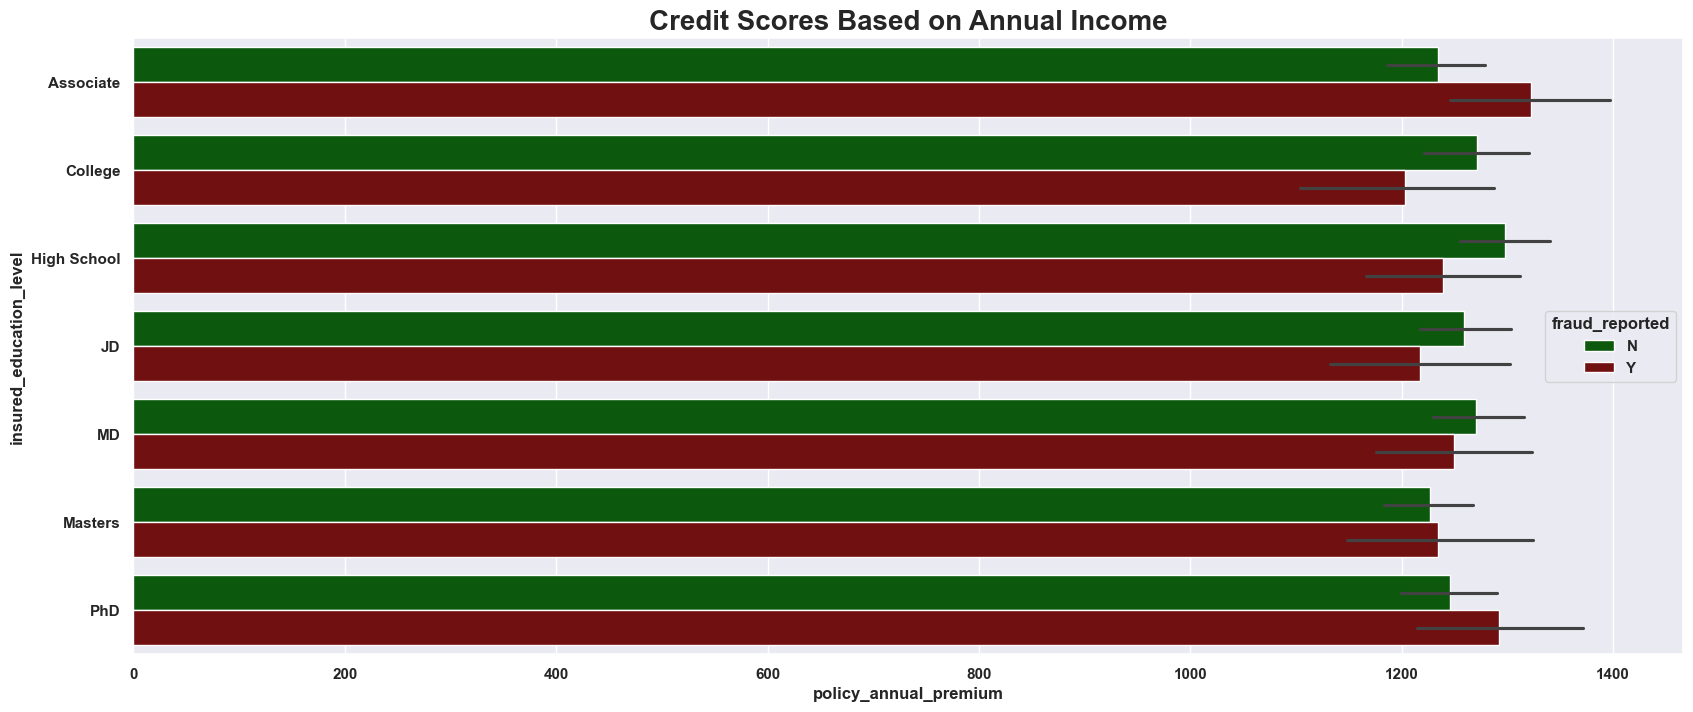

In [16]:
plt.figure(figsize=(20,8))
sns.barplot(data=df,x='policy_annual_premium', y='insured_education_level',hue='fraud_reported',hue_order=['N','Y'],palette=['darkgreen','maroon'])
plt.title("Credit Scores Based on Annual Income",fontdict={'fontsize':20,'fontweight':'bold'})

Text(0.5, 1.0, 'Credit Scores Based on Annual Income')

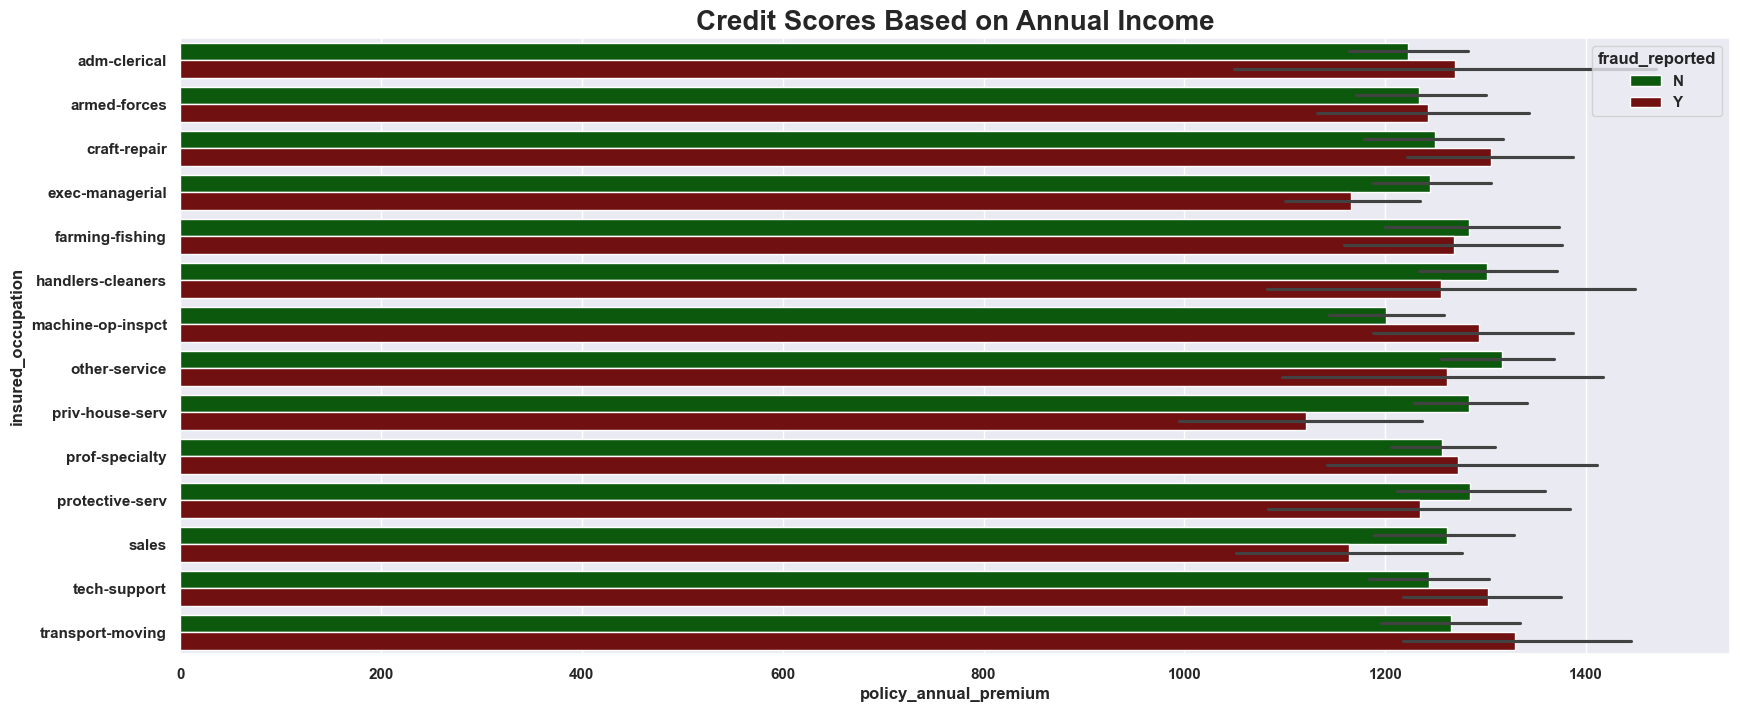

In [17]:
plt.figure(figsize=(20,8))
sns.barplot(data=df,x='policy_annual_premium', y='insured_occupation',hue='fraud_reported',hue_order=['N','Y'],palette=['darkgreen','maroon'])
plt.title("Credit Scores Based on Annual Income",fontdict={'fontsize':20,'fontweight':'bold'})

Text(0.5, 1.0, 'Credit Scores Based on Annual Income')

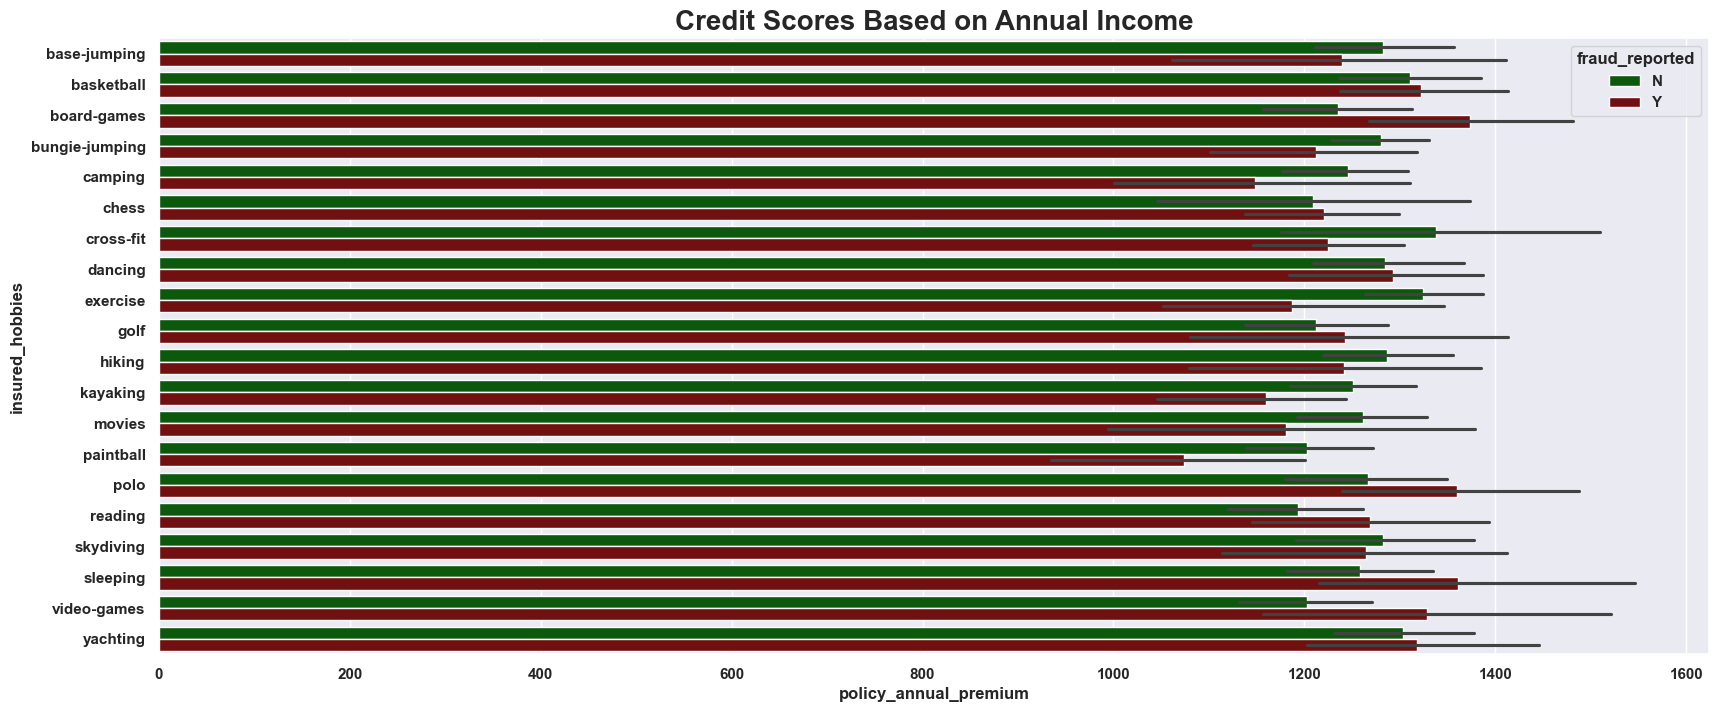

In [18]:
plt.figure(figsize=(20,8))
sns.barplot(data=df,x='policy_annual_premium', y='insured_hobbies',hue='fraud_reported',hue_order=['N','Y'],palette=['darkgreen','maroon'])
plt.title("Credit Scores Based on Annual Income",fontdict={'fontsize':20,'fontweight':'bold'})

Text(0.5, 1.0, 'Credit Scores Based on Annual Income')

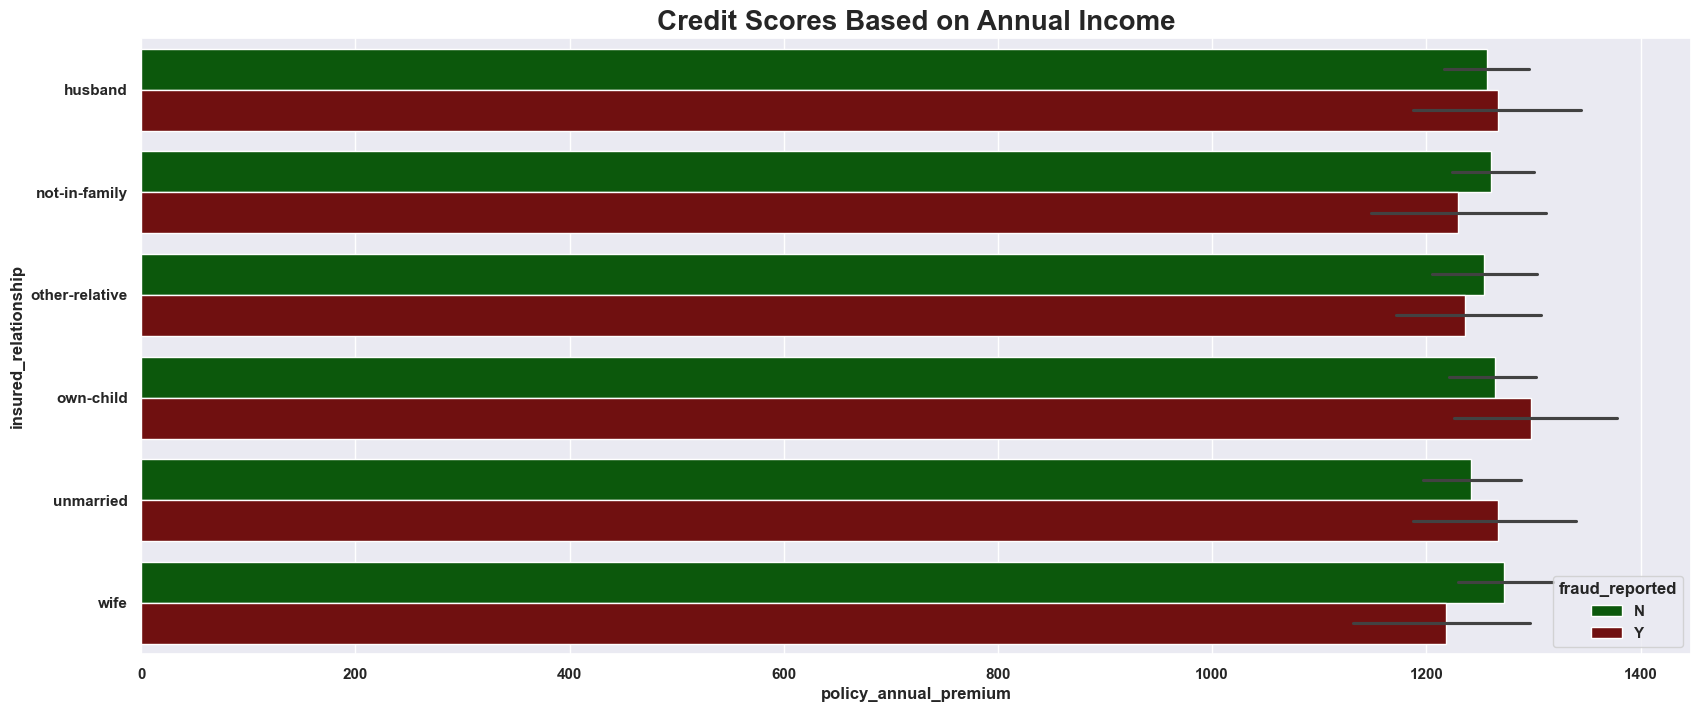

In [19]:
plt.figure(figsize=(20,8))
sns.barplot(data=df,x='policy_annual_premium', y='insured_relationship',hue='fraud_reported',hue_order=['N','Y'],palette=['darkgreen','maroon'])
plt.title("Credit Scores Based on Annual Income",fontdict={'fontsize':20,'fontweight':'bold'})

### <p Style="color: Khaki">Correlation - Pearson's and Spearman's </p>

In [2]:
sns.set_theme(font_scale=1.5)

cor_col = df.select_dtypes(include='number')
correlation_matrix_pear = cor_col.corr(method='pearson')
plt.figure(figsize=(40,15))

sns.heatmap(correlation_matrix_pear,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('\nPearson Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
plt.show()

NameError: name 'sns' is not defined

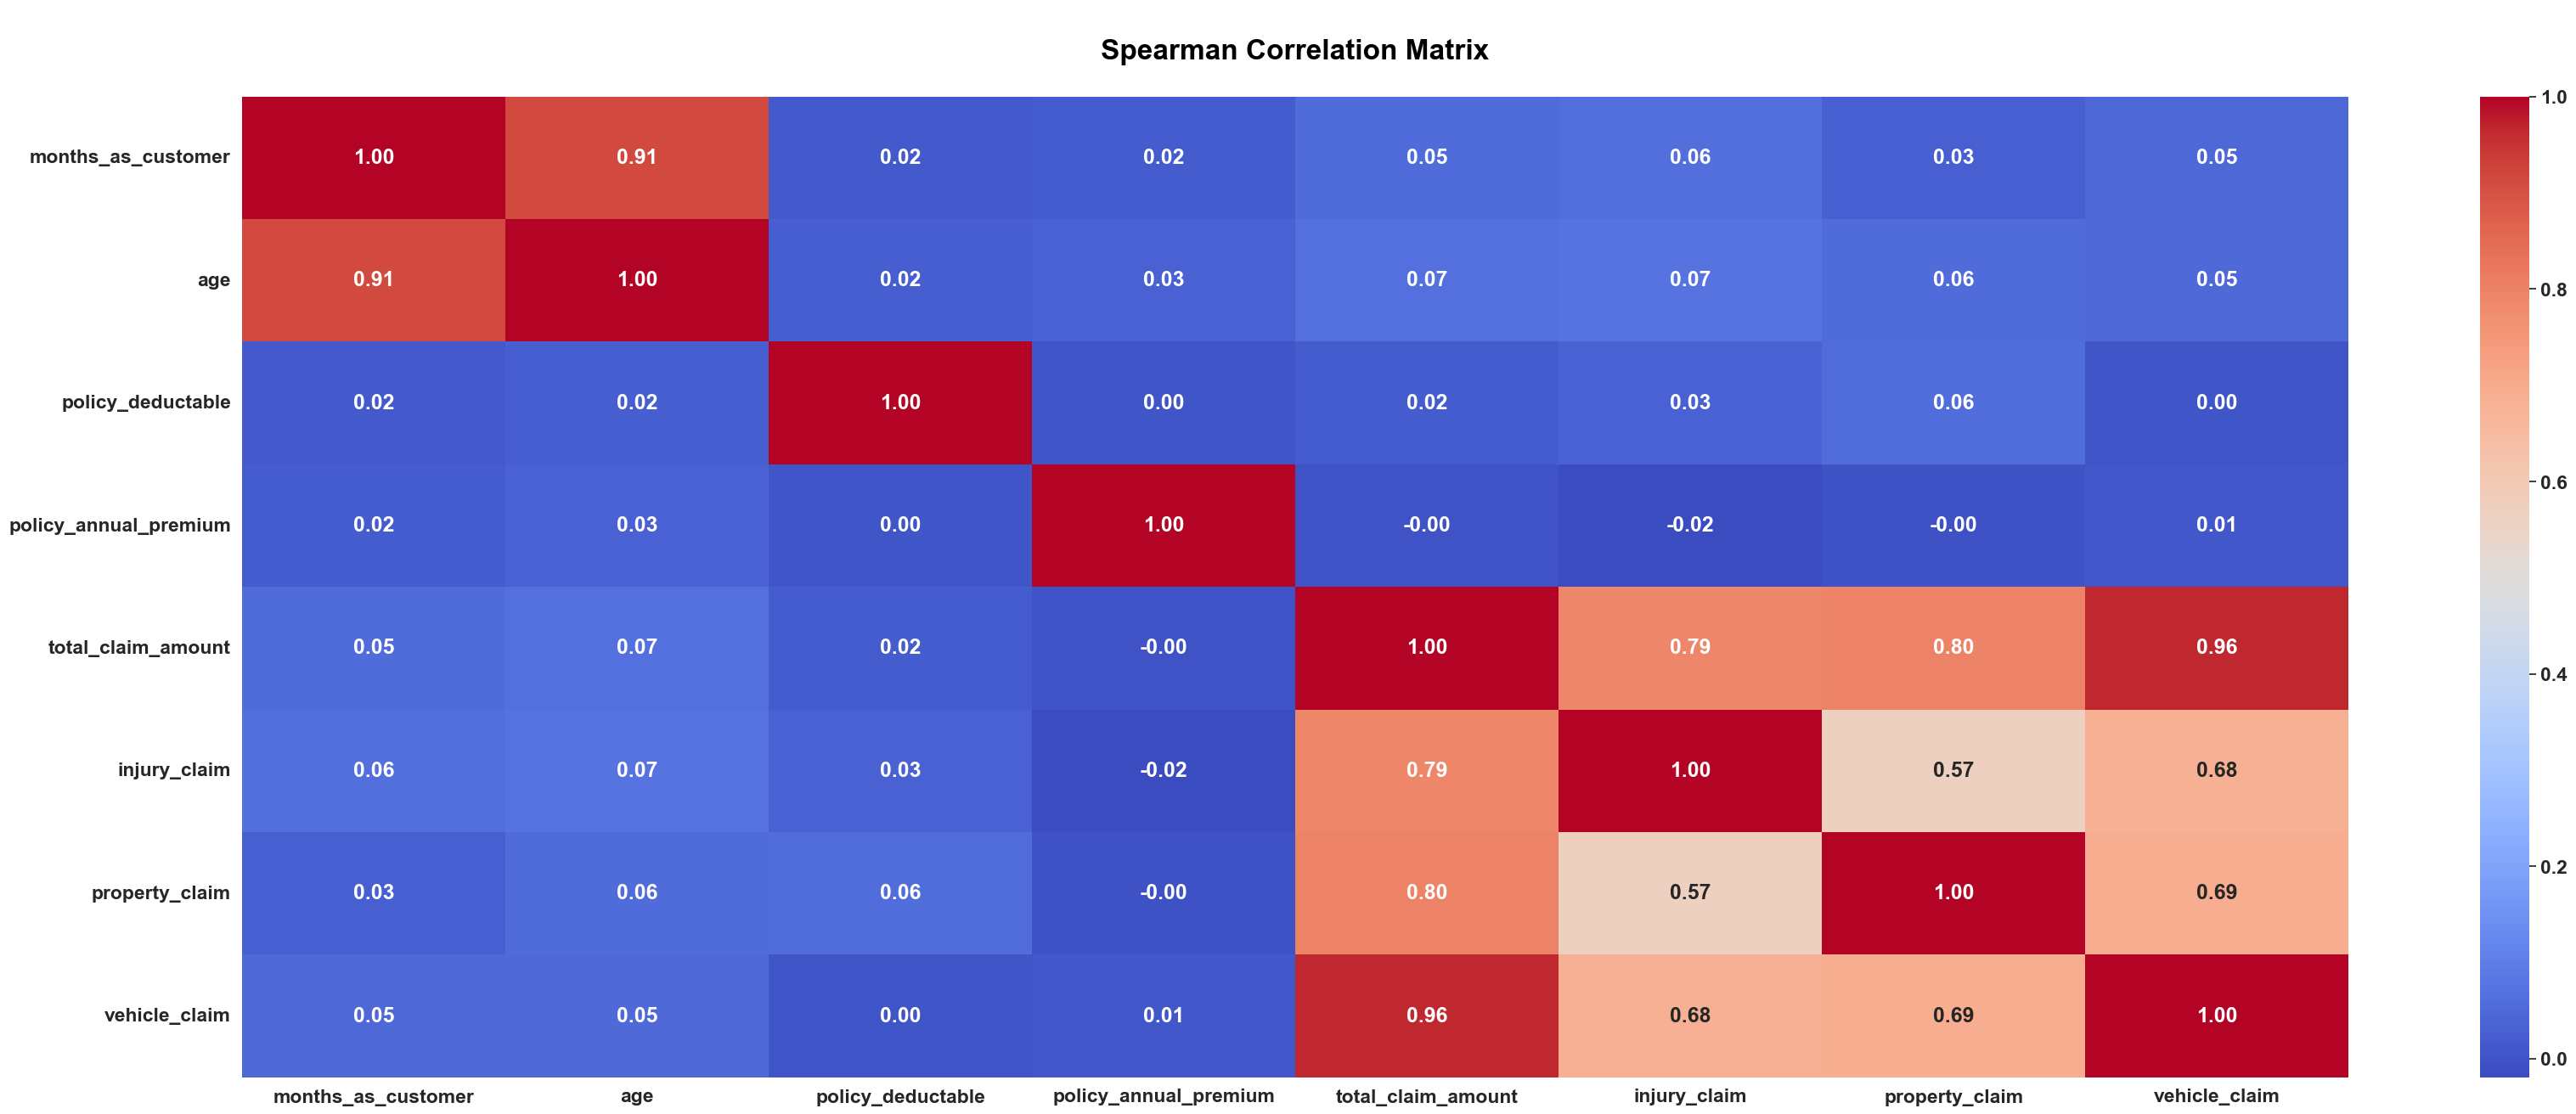

In [26]:
plt.figure(figsize=(40,15))

cor_col = df.select_dtypes(include='number')
correlation_matrix = cor_col.corr(method='spearman')
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('\nSpearman Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

plt.show()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           1000 non-null   int16         
 1   age                          1000 non-null   int8          
 2   policy_bind_date             1000 non-null   datetime64[ns]
 3   policy_state                 1000 non-null   category      
 4   policy_deductable            1000 non-null   int16         
 5   policy_annual_premium        1000 non-null   float64       
 6   insured_sex                  1000 non-null   category      
 7   insured_education_level      1000 non-null   category      
 8   insured_occupation           1000 non-null   category      
 9   insured_hobbies              1000 non-null   category      
 10  insured_relationship         1000 non-null   category      
 11  incident_date                1000 non-null  